# Machine Learning of catchment-features in river runoff time-series

- Cano Amaro Germán
- Monti Sebastiano
- Tonazzo Valentina
- Zoppellari Elena

Supervisor: professor Carlo Albert

## Useful libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from sklearn.metrics import mean_squared_error as mse

import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from IPython.display import Image
import plotly.graph_objects as go

## Rainfall-Runoff Modelling 

Rainfall-runoff modelling remains still an unresolved problems among hydrological sciences. Along history several aproaches have been tried such as predict the discharge as a function of precipitation events or refined models with explicit properties of the catchments. The computational cost of these models is progresively increasing so usually less complex models are used even though they are not that reliable. 

Here we tried to use the advantages of deep neural networks in terms of computational costs and prediction capacity to tackle this problem. Specifically,the principal purpose of this project is to integrate the train of a LSTM neural network with the summary statistics provided by an econder. We want to verify if the latter, enclosing the main characteristics of different hydrological basins, could help to improve prediction for those catchments with poor informations. 

<img src='rainfall_runoff.jpeg' width="600" height="600" align="center"/>

#### Description of CAMELS dataset 

The data that have been analyzed in this project are part of a larger dataset, called CAMELS dataset, where the acronym stands for "Catchment Attributes for Large-Sample Studies".
This dataset is freely available on the web and contains daily meteorological data and measured discharge for 671 catchments with minimal human disturbance, across the United States. For most catchments the data acquisition started in 1980, consisting of day length, precipitation, short-wave downward radiation, maximum and minimum temperature, snow-water equivalent and humidity.
All the catchments from the dataset are grouped into 18 hydrological units following the U.S. Geological Survey's map. These groups correspond to geographic areas that represent the drainage area of either a major river or the combined drainage areas of a series of rivers, discerning more arid catchments from more humid ones.
In our particular case, the measures that have been used are the ones of discharge, precipitations and temperatures of 569 basins for a time period of 30 years, starting from 1980-10-01. Each basin is identified by its proper (unique) ID, from which it is possible to access to the geographical location and the humidity level of the catchment.

In [3]:
df = pd.read_csv('/CAMELS_US_time_series.csv')
dft = df.transpose()
dft.columns = dft.iloc[0]
dft = dft.iloc[1: , :]
dft

time,01013500_Q,01013500_P,01013500_T,01013500_D,01022500_Q,01022500_P,01022500_T,01022500_D,01030500_Q,01030500_P,...,14316700_T,14316700_D,14325000_Q,14325000_P,14325000_T,14325000_D,14400000_Q,14400000_P,14400000_T,14400000_D
1980-10-01,0.550998,3.1,11.105,11.327992,0.932543,0.0,19.885,11.423997,0.706441,2.42,...,25.66,11.424011,0.106246,0.0,28.38,11.423994,0.226668,0.0,29.37,11.424
1980-10-02,0.560741,4.24,18.44,11.283633,0.790996,0.0,21.74,11.327997,0.673119,1.89,...,29.415,11.328025,0.106246,0.0,33.885,11.423994,0.216207,0.0,34.805,11.424
1980-10-03,0.558576,8.02,19.765,11.231994,0.711896,5.96,22.94,11.295883,0.673119,10.06,...,32.525,11.328025,0.100654,0.0,31.815,11.327997,0.209232,0.0,27.59,11.327997
1980-10-04,0.671157,15.27,12.93,11.135989,1.315551,31.3,18.745,11.232,0.86639,21.23,...,30.17,11.231989,0.100654,0.0,27.16,11.314844,0.202258,0.0,27.79,11.327997
1980-10-05,0.821626,8.48,8.59,11.135989,1.902554,2.39,16.115,11.135994,1.519516,1.56,...,31.345,11.231989,0.095062,0.0,28.08,11.232,0.198771,0.0,26.045,11.232003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-09-26,0.649507,2.07,16.665,11.712008,0.283093,0.07,26.125,11.712,0.276578,0.75,...,28.205,11.712003,0.212492,0.0,25.77,11.712003,0.470772,0.0,25.365,11.711997
2010-09-27,0.634351,1.57,18.14,11.616006,0.262278,0.0,18.365,11.615997,0.34589,2.17,...,30.84,11.712003,0.201309,0.0,28.035,11.712003,0.449849,0.0,26.57,11.711997
2010-09-28,0.691724,14.67,23.505,11.560081,0.262278,4.14,23.685,11.615997,0.383211,7.26,...,30.445,11.616003,0.195717,0.0,28.3,11.616003,0.432413,0.0,27.32,11.616003
2010-09-29,0.814048,10.05,26.555,11.520014,0.299746,3.91,29.945,11.520003,0.399206,3.5,...,30.1,11.557072,0.190125,0.0,29.025,11.616003,0.414977,0.0,30.415,11.616003


The following cell creates a list with all the basins' codes, containing all identifiers numbers of the basins.

In [4]:
#List containing all the basins' codes
basins = []
control = str() #parameter to control the uniqueness of the code
for code in dft.columns:
    code = list(code) #the original code string is converted to a list of strings in order to remove the attributes Q, T, P, D
    del code[8:]
    code = ''.join(code)
    if code != control:
        basins.append(code)
    control = code
    
print(f"There are {len(basins)} basins.")

There are 569 basins.


Aridity is defined as the fraction of the precipitation falling as snow, and
the seasonality and timing of precipitation. The hum dataframe sumarizes some properties of each catchemnt such as aridity corresponding to each basins id. 

In [5]:
IDs = [int(ID) for ID in basins]

coord = pd.read_csv('/camels_topo.txt', delimiter=';')
coord = coord.loc[coord['gauge_id'].isin(IDs)]  

hum = pd.read_csv('/camels_clim.txt', delimiter=';')
hum = hum.loc[hum['gauge_id'].isin(IDs)]  

attr =  pd.read_csv('/camels_name.txt', delimiter=';')
attr = attr.loc[attr['gauge_id'].isin(IDs)]

catch_info = coord.set_index('gauge_id').join(hum.set_index('gauge_id'), how='inner')
catch_info = catch_info.join(attr.set_index('gauge_id'), how='inner')
catch_info['text'] = catch_info.index.astype(str) + ', ' + catch_info['gauge_name']

In [6]:
aridities = list(hum['aridity'])

Here we create an array containing all dates of the dataset (first column in the previous dft) it is a numpy array with type 'datetime64'.

In [7]:
#Array containing all the dates
dates = np.array(df.columns.values[1:], dtype='datetime64')

print(f"There are {len(dates)} time data.")

There are 10957 time data.


In [8]:
fig = go.Figure(data=go.Scattergeo(
        locationmode = 'USA-states',
        lon = catch_info['gauge_lon'],
        lat = catch_info['gauge_lat'],
        text = catch_info['text'],
        mode = 'markers',
        marker = dict(
            size = 8,
            opacity = 0.8,
            reversescale = True,
            autocolorscale = False,
            symbol = 'circle',
            line = dict(
                width=1,
                color='rgba(102, 102, 102)'
            ),
            colorscale = 'Rainbow',
            cmin = 0,
            color = catch_info['aridity'],
            cmax = catch_info['aridity'].max(),
            colorbar_title="Basins' aridity"
        )))

fig.update_layout(
        title = 'CAMELS dataset basins',
        geo = dict(
            scope='usa',
            projection_type='albers usa',
            showcoastlines=True, coastlinecolor="RebeccaPurple",
            showland=True, landcolor="LightGreen",
            showocean=True, oceancolor="LightBlue",
            showlakes=True, lakecolor="Blue",
            showrivers=True, rivercolor="Blue"
        ),
    )

fig.show()

## Data visualization

This is simply an example plot in function of time of Discharge Q, Temperature T and Pression P for the first basin, the latter is identified by string "01013500".

Text(0, 0.5, 'T(C)')

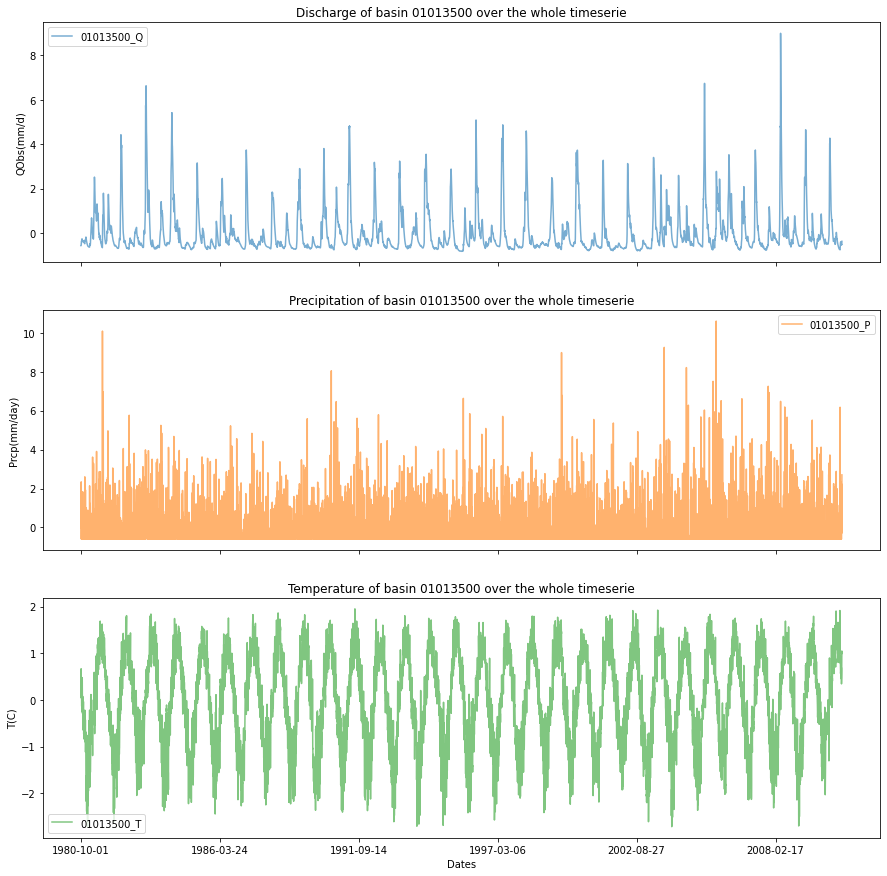

In [9]:
#Visualization of data for a fixed basin
basin = basins[0]
Q = f"{basin}_Q"
P = f"{basin}_P"
T = f"{basin}_T"
df0 = dft.loc[:, [Q, P, T]]
df0 = (df0 - df0.mean())/df0.std()
axes = df0.plot(alpha = 0.6,subplots=True, figsize = (15,15),
         title=[f"Discharge of basin {basin} over the whole timeserie",
                f"Precipitation of basin {basin} over the whole timeserie",
                f"Temperature of basin {basin} over the whole timeserie"])
axes[0].set_xlabel('Dates')
axes[1].set_xlabel('Dates')
axes[2].set_xlabel('Dates')
axes[0].set_ylabel('QObs(mm/d)')
axes[1].set_ylabel('Prcp(mm/day)')
axes[2].set_ylabel('T(C)')

#### LSTM (Long Short-Term Memory)

Rainfall–runoff modelling is one of the key challenges in the field of hydrology. Various approaches exist, ranging from physically based over conceptual to fully data-driven models. In this project it was used a data-driven approach, using the Long Short-Term Memory (LSTM) network, a special type of recurrent neural network. The advantage of the LSTM is its ability to learn long-term dependencies between the provided input and output of the network, which are essential for modelling storage effects in e.g.
catchments with snow influence.
The differences of the traditional RNN and the LSTM are the internal operations of the recurrent cell. In a traditional RNN cell, only one internal state $h_t$ exists, which is recomputed in every time step by the following equation: 

$h_t = g ( W x_t + U h_{t-1} + b )$

where $g(·)$ is the activation function, $W$ and $U$ are the adjustable weight matrices of the hidden state $h$ and the input $x$, and $b$ is an adjustable bias vector.
In comparison, the LSTM has (i) an additional cell state or cell memory c t in which information can be stored, and (ii) gates that control the information flow within the LSTM cell. 

<img src='LSTM.jpg' width="400" height="400" align="center"/>


Initialization of some useful constants. We decided to define them globally in order to make the whole program more general, they will be used in the definition of the model.

In [10]:
#Useful global parameters
lookback = 365           #Lookback time window of one year, to learn the discharge from the model
predicted_days = 7       #Number of predicted discharge days
N_features = 3           #Number of output catchment features from the encoder
N_years = 30             #Number of data acquisition years in the dataset

In [11]:
LSTM = tf.keras.layers.Input(shape = (None, 2),  name= 'LSTMinput')#to change manually the number of features

x = tf.keras.layers.LSTM(units = 30, return_sequences=True)(LSTM)
x = tf.keras.layers.LSTM(units = 30)(x)
x = tf.keras.layers.Dense(units = 30, activation='relu')(x)

outputLSTM = tf.keras.layers.Dense(units = predicted_days, activation='linear')(x)


model1 = tf.keras.Model(inputs=[LSTM], outputs = [outputLSTM], name = 'model')

model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTMinput (InputLayer)      [(None, None, 2)]         0         
                                                                 
 lstm (LSTM)                 (None, None, 30)          3960      
                                                                 
 lstm_1 (LSTM)               (None, 30)                7320      
                                                                 
 dense (Dense)               (None, 30)                930       
                                                                 
 dense_1 (Dense)             (None, 7)                 217       
                                                                 
Total params: 12,427
Trainable params: 12,427
Non-trainable params: 0
_________________________________________________________________


From now on, we will use the name $\text{model 1}$ referring to the LSTM model alone.

### Autoencoder

Autoencoders are types of neural networks based on reduction and reconstruction of the data in order to keep the minimun but yet most important parameters to describe the data while cancelling the noise. They are usually formed by two neural networks, an encoder that maps the input into the code, and a decoder that maps the code to a reconstruction of the input; they work together as an unique network. 

In this specific case, the encoder is supposed to learn the summary statistics, $s(Q)$, which consist in non-physical data that represent the most important characteristics for each different basin. The main property of this characteristics is the time-independency, they in fact assume fixed and specific values for each basin. The summary statics, together with temperature, $T$, and precipitations, $P$, are used as input features for an LSTM structure similar to the previous one, whose job is to reconstruct the discharge $Q$.   


<img src='autoencoder.jpg' width="800" height="700" align="center"/>


The enconder model consisted on a one dimensional convolutional neural network: convolutional layers that classify the data through a settled number of features and MaxPooling layers which extract the highest and thus more relevant values from the convolutional layers. This kind of networks are widely used for example in image procesing but also, as in our case, in physics problems where symmetries can be exploited.

Here we can see an example of how a two dimensional Convolutional layers works:
<img src='cnn.png' width="600" height="600" align="center"/>

And the maxpool operation: 

<img src='MaxpoolSample2.png' width="500" height="500" align="center"/>


Below My_loss_fn is defined: a customized loss function, that calculates the loss between the LSTM output and the last chosen measured days of discharge. This function will be used in the final loop to improve the training.

In [12]:
# Proper loss function between measurements and predictions for the autoencoder
def my_loss_fn(y_true, y_pred):
    
    '''y_true: true labels (discharge values)
    y_pred: predictions of the discharge from the autoencoder'''
    
    return tf.keras.metrics.mean_squared_error(y_true, y_pred)     #The loss function is defined as mean squared error

In [13]:
input_enc = tf.keras.Input(shape=(None, 1), name = 'encinput')  #Input() is used to instantiate a Keras tensor.

x = input_enc

num_conv_filters = [[16, 16], [32, 32]]  #A matrix 2x2

for t in range(len(num_conv_filters)):   #2 cicles, len(num_conv_filters)=2

    if t != 0:        #if we are in the second cicle

        x = tf.keras.layers.MaxPool1D(pool_size = 2, name = 'maxpool%d'%(t+1))(x)  #Max pooling operation for temporal data.

    for j in range(len(num_conv_filters[t])):    #2 cicles, len(num_conv_filters[t]) = 2, working on columns of num_conv_filters matrix

        x = tf.keras.layers.Conv1D(filters = num_conv_filters[t][j], kernel_size = 3, 
                                    activation = 'relu', name = 'conv%d_%d'%((t+1), (j+1)))(x)


x = tf.keras.layers.Conv1D(filters = N_features, kernel_size = 3, activation = None, name = 'final_conv')(x)
## the number of filters determine the number of outputs of our encoder
output1 = tf.keras.layers.GlobalAveragePooling1D(name='global_avg_pool1')(x)


LSTM = tf.keras.layers.Input(shape = (None, 2),  name = 'lstminput')#to change manually the number of features

catch_prop = tf.tile(tf.expand_dims(output1, axis = 1),  multiples = [1, tf.shape(LSTM)[1], 1]) 

#LSTM and catch_prop must have the same dimensions except on the axis we are concatenating them, catch_prop have dim=(1,365,3) 

concat_inputs2 = tf.keras.layers.Concatenate(axis = -1, name = 'concatlayer' )([LSTM, catch_prop])

concat_inputs = concat_inputs2[:, :-predicted_days, :]

x = tf.keras.layers.LSTM(units = 30, return_sequences = 'True', name = 'lstm1')(concat_inputs)
x = tf.keras.layers.LSTM(units = 30,  name = 'lstm2')(x)
x = tf.keras.layers.Dense(units = 30, activation = 'relu')(x)

outputLSTM = tf.keras.layers.Dense(units = predicted_days, activation = 'linear')(x)


model2 = tf.keras.Model(inputs = [input_enc, LSTM], outputs = [outputLSTM], name = 'model')
model2.add_loss(my_loss_fn(input_enc[:, -predicted_days:], outputLSTM)) # Notice we are computing the loss over the last days of the year.

model2.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encinput (InputLayer)          [(None, None, 1)]    0           []                               
                                                                                                  
 conv1_1 (Conv1D)               (None, None, 16)     64          ['encinput[0][0]']               
                                                                                                  
 conv1_2 (Conv1D)               (None, None, 16)     784         ['conv1_1[0][0]']                
                                                                                                  
 maxpool2 (MaxPooling1D)        (None, None, 16)     0           ['conv1_2[0][0]']                
                                                                                              

From now on, we will be referring to the autoencoder model with the name $\text{model 2}$.

## Useful functions

Initialization of some useful constants. We decided to define them globally in order to make the whole program more general, they will be used in the definition of the model as well as in training and validation parts

In [14]:
#Useful parameters referred to data:

train_perc = 0.6         #Fraction of samples over the total set of measurements used for training
val_perc = 0.2           #Fraction of samples over the total set of measurements used fot validation
N_basins = len(basins)   #Number of basins feeded to the models
N_train_samples = int((len(dates) - lookback)*train_perc)
N_val_samples = int((len(dates) - lookback)*val_perc)

#### This is a set of 8 customized functions. They will be used to reshape and model the data in order to get the right inputs for the implemented models of encoder, decoder (LSTM) and autoencoder. 

1) df_normal: Normalize each column of the whole dataset, basin by basin, storing the standard deviation and the mean of the discharge, in order to return back to the original unnormalized representation.


2) filter_df: Shuffle the dataset so that each block of 365 rows corresponds to a random year from a random basin.



3) df_to_X_y_auto: It is used to create inputs data for the encoder, LSTM and autoencoder. For each year of forecast, for a considered basin, the encoder needs a lookback=365 sample's size of Q which are denominated y_enc. The LSTM, instead, needs the same lenght of samples for P and T as features, X. The corresponding labels, y, for the LSTM forecast are the last predicted days of the selected year. All these sets are expressed as numpy arrays, from the moment that keras requires them.

  

4) As usual in ML aproach the total dataset should be divided into training, validation and test sets. 
   The first one  is used to train and make the model learn the hidden features/patterns in the data, in each epoch, the same training data is fed to the neural network architecture repeatedly, and the model continues to learn the features of the data. 
   The validation set is used to validate our model performance during the training; this validation process gives information that helps us tune the model’s hyperparameters and configurations accordingly. It is like a critic telling us whether the training is moving in the right direction or not. The model is trained on the training set, and, simultaneously, the model evaluation is performed on the validation set after each epoch.
   The test set is s a separate set of data, used to test the model after completing the training. This avoids the evaluation from being biased. The splitting explained above is done in train_val_test_auto funtion.

5) calc_nse: is a function (from Kratzert's code) used to evaluate the NSE parameter. The Nash–Sutcliffe model efficiency coefficient (NSE) is used to assess the predictive skill of hydrological models. It is defined as:

$$ NSE=1-{\frac {\sum _{t=1}^{T}\left(Q_{o}^{t}-Q_{m}^{t}\right)^{2}}{\sum _{t=1}^{T}\left(Q_{o}^{t}-{\overline {Q}}_{o}\right)^{2}}} $$

In the code it will be calulated over the raw Q predictions (not reconstructed) and the Q labels normalized.

6) right_shape: Useful for showing the results, it matchs again the data to each basin and gives the std, mean, basin code, prediction dates and aridity index of the original discharge to reconstruct the data.

7) Plot function for a single basin for all years contained in the test set. It returns the predicted days of both lstm and autoencoder in comparison with the "true" values of the discharge, and useful information as the NSE efficenty of both the models for this specific basin and the loss value. The predictions are shown reconstructed, i.d. removing the normalization. It returns also the number of predictions which have a percentual error smaller than 10%.

8) extract_collect: used to extract the test elements produced with right_shape and to create $\text{test basins}$, a list which contains all the basins in the test set picked once and $\text{test aridity}$, a list which contains the aridity values of the basins in the test set in the same order as $\text{test basins}$.

In [15]:
# 1) Data preparation for the autoencoder, for a fixed number of basins
def df_normal(df = dft, basins = basins, N_basins = N_basins):
    
    '''dft: transposed dataframe containing all the data
    basins: list of codes of all basins, 
    N_basins: fixed number of basins we want to analyze''' 
    
    df_norm = pd.DataFrame()
    n=0
    for i in basins[:N_basins]:
    
        Q = f"{i}_Q"      #string: concatenation of specific basin index and Q indicating discharge
        P = f"{i}_P"      #string: concatenation of specific basin index and P indicating precipitation
        T = f"{i}_T"      #string: concatenation of specific basin index and T indicating temperature
      
      
        df_norm1 = df.loc[:, [Q, P, T]]                          #Selection of the data related to the chosen basins
        std = df_norm1.std()
        mean = df_norm1.mean()
        df_norm1 = (df_norm1 - df_norm1.mean())/df_norm1.std()   #Data normalization
        df_norm1.columns = ['Q','P','T']
        df_norm1 = df_norm1.assign(basin = [i]*df_norm1.shape[0])
        df_norm1 = df_norm1.assign(std_Q = std[0])
        df_norm1 = df_norm1.assign(mean_Q = mean[0])
        df_norm1 = df_norm1.assign(aridity = aridities[n])
        df_norm = pd.concat([df_norm, df_norm1], axis = 0)
        n = n+1
      
    return df_norm

# 2) Filtering the output dataframe from function 1)
def filter_df(df, lookback = lookback):
    
    '''df: output dataframe from function df_normal
    lookback: time window used to predict the data'''
    
    norm_df = df[df.index.str.find('-02-29') < 0]                   #taking out the 29 of february so the length of the dataset is multiple of 365 
    norm_df = norm_df.assign(index = np.arange(norm_df.shape[0]))   #adding a column with numbers that will be helpful
    np.random.shuffle(norm_df['index'].values.reshape(-1, lookback, norm_df.shape[1]-2))   #shuffling the numbers we added at the previous step by blocks of 365
    norm_df = norm_df.iloc[norm_df['index'].argsort()]              #reordering the whole dataset based on the shuffle
    norm_df = norm_df.drop(columns = 'index')                       #deleting the extra column that is not needed anymore
    
    return norm_df

# 3) Creating numpy arrays from output dataframes of functions 1) or 2). Useful because keras works with numpy arrays
def df_to_X_y_auto(df, lookback = lookback, N_basins = N_basins, N_years = N_years, predicted_days = predicted_days):
    
    '''df: output dataframe from function df_normal or from function filter_df
    N_years: integer number specifying the time length in years of data acquisition
    predicted_days: number of days we want to predict with the autoencoder'''
    
    df_as_np = df.to_numpy().astype(np.float32)
    X = []             #shape: (N_basins*N_years, 365, 2 = T,P)
    y = []             #shape: (N_basins*N_years, 1 = Q)
    y_enc = []         #shape: (N_basins*N_years, 365)
    for i in range(N_basins*N_years): 
        row = df_as_np[(i*lookback):((i*lookback) + lookback), 1:3]
        X.append(row)
        label =  df_as_np[(i*lookback)+(lookback - predicted_days):((i*lookback) + lookback), 0]
        y.append(label)
        discharge = df_as_np[(i*lookback):((i*lookback) + lookback), 0]
        y_enc.append(discharge)
    return np.array(X), np.array(y), np.array(y_enc)

# 4) Train, validation and test splitting of the output arrays of function 3) 
def train_val_test_auto(X, y, y_enc, train_perc = train_perc, val_perc = val_perc, lookback = lookback):
    
    '''X, y, y_enc: output numpy arrays from function df_to_X_y_auto
    train_perc: percentage of data we want to use for training
    val_perc: percentage of data we wanto to use for validation'''
    
    X_train, y_train, y_enc_train = X[:int(train_perc*len(X)),:], y[:int(train_perc*len(y))], y_enc[:int(train_perc*len(y_enc))]
    X_val, y_val, y_enc_val = X[int(train_perc*len(X)):int((train_perc+val_perc)*len(X)),], y[int(train_perc*len(y)):int((train_perc+val_perc)*len(y))], y_enc[int(train_perc*len(y_enc)):int((train_perc+val_perc)*len(y_enc))]
    X_test, y_test, y_enc_test = X[int((train_perc+val_perc)*len(X)):,:], y[int((train_perc+val_perc)*len(y)):], y_enc[int((train_perc+val_perc)*len(y_enc)):]
    
    #Now we adjust the shape of y_enc, in order to match it with the input shape of the encoder
    y_enc_train = np.resize(y_enc_train, new_shape = (y_enc_train.shape[0], lookback, 1))
    y_enc_val = np.resize(y_enc_val, new_shape = (y_enc_val.shape[0], lookback, 1))
    y_enc_test = np.resize(y_enc_test, new_shape = (y_enc_test.shape[0], lookback, 1))
    
    return X_train, y_train, y_enc_train, X_val, y_val, y_enc_val, X_test, y_test, y_enc_test


# 5) Nash-Sutcliff efficiency calculation
def calc_nse(obs: np.array, sim: np.array) -> float:
    
    '''obs: Array containing the observations
    sim: Array containing the simulations''' 
    
    # Nash-Sutcliff efficiency calculation
    denominator = np.sum((obs - np.mean(obs)) ** 2)      
    numerator = np.sum((sim - obs) ** 2)
    nse_val = 1 - numerator / denominator   #the actual code for NSE

    return nse_val


# 6) To match exactly the year and the basin of each couple (label, prediction)
def right_shape(df, lookback = lookback, N_basins = N_basins, N_years = N_years, predicted_days = predicted_days):
    
    dates_new = np.array(df.index, dtype='datetime64')
    df_as_np = df.to_numpy().astype(np.float32)
    means = []
    stds = []
    basin_order = []
    dates = []
    index_aridity = []
    for i in range(N_basins*N_years): 
        bas =  df_as_np[(i*lookback)+(lookback - predicted_days):((i*lookback) + lookback), 3]
        mu =  df_as_np[(i*lookback)+(lookback - predicted_days):((i*lookback) + lookback), 4]
        sigma =  df_as_np[(i*lookback)+(lookback - predicted_days):((i*lookback) + lookback), 5]
        days =  dates_new[(i*lookback)+(lookback - predicted_days):((i*lookback) + lookback)]
        aridity = df_as_np[(i*lookback)+(lookback - predicted_days):((i*lookback) + lookback), 6]
        basin_order.append(bas)
        means.append(mu)
        stds.append(sigma)
        dates.append(days)
        index_aridity.append(aridity)
    return np.array(means), np.array(stds), np.array(basin_order), np.array(dates), np.array(index_aridity)

# 7) Plot function for a single basin and a single year of the test set. 
# It returns the predicted days in comparison with the "true" values of the discharge, and useful information
# as the NSE efficenty of the model for this specific basin and the loss value.
# It returns also the number of predictions which have a percentual error smaller than 10%.

def plot(index, y_pred1, y_pred2, days = predicted_days):
    basin = basins_order[index] # code of the basin
    date_range = dates_new[index] # dates of the predictions
    perc1 = abs((y_pred1[index]-y_test_true[index])/y_test_true[index])*100 # precentual error
    perc2 = abs((y_pred2[index]-y_test_true[index])/y_test_true[index])*100 # precentual error
    index2 = [i for i, n in enumerate(test_basins) if n==basin][0]
    nse1 = list(nse_collect1.values())[index2]
    loss1 = list(loss_collect1.values())[index2]
    mse1 = list(mse_collect1.values())[index2]
    nse2 = list(nse_collect2.values())[index2]
    loss2 = list(loss_collect2.values())[index2] 
    mse2 = list(mse_collect2.values())[index2]
    df = pd.DataFrame(data = {'Q labels':y_test_true[index],'Predictions LSTM':y_pred1[index], 'Error LSTM (%)':perc1,'Predictions Autoencoder':y_pred2[index], 'Error Autoencoder (%)':perc2}, index = date_range)   #a dataframe to collect all data
    best = 10
    df_best1 = df[df['Error LSTM (%)'] < best]                     #selecting from dataframe the best samples, ones with percentage error smaller that 10%
    df_best2 = df[df['Error Autoencoder (%)'] < best]                     #selecting from dataframe the best samples, ones with percentage error smaller that 10%
    result1 = round((len(df_best1.index)/len(df.index))*100,2)
    result2 = round((len(df_best2.index)/len(df.index))*100,2)
    print(f"LSTM: Predictions with less than {best}% error are {len(df_best1.index)} out of {len(df.index)}, it means {result1}%.")
    print(f"Autoencoder: Predictions with less than {best}% error are {len(df_best2.index)} out of {len(df.index)}, it means {result2}%.")
    year = date_range[0].astype('datetime64[Y]').astype(int)+ 1970

    # Plot test results
    display(df)
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize = (20, 5))
    fig.suptitle(f'basin: {basin}, year: {year}')
    ax1.plot(date_range, df['Q labels'][:], label = "observation")
    ax1.scatter(date_range, df['Predictions LSTM'][:], label = "prediction lstm", color="orange")
    ax1.errorbar(date_range, df['Predictions LSTM'][:], yerr=mse1, color="red", alpha=0.2)
    ax1.legend(loc="best")
    ax1.set_title(f"LSTM model - test set NSE: {nse1:.3f} - loss: {loss1:.3f}")
    ax1.xaxis.set_tick_params(rotation = 90)
    ax1.set_xlabel("Date")
    _ = ax1.set_ylabel("Discharge (mm/d)")
    ax2.plot(date_range, df['Q labels'][:], label = "observation")
    ax2.scatter(date_range, df['Predictions Autoencoder'][:], label = "prediction autoencoder", color="orange")
    ax2.errorbar(date_range, df['Predictions Autoencoder'][:], yerr=mse2, color="red", alpha=0.2)
    ax2.legend(loc="best")
    ax2.set_title(f"Autoencoder model - test set NSE: {nse2:.3f} - loss: {loss2:.3f}")
    ax2.xaxis.set_tick_params(rotation = 90)
    ax2.set_xlabel("Date")
    _ = ax2.set_ylabel("Discharge (mm/d)")

# 8) extract useful objects
def extract_collect(means, stds, basins_order, dates_new, index_aridity):

    #Extraction of the values of only the test set
    means = means[int((train_perc+val_perc)*len(means)):]
    stds = stds[int((train_perc+val_perc)*len(stds)):]
    basins_order = basins_order[int((train_perc+val_perc)*len(basins_order)):]
    dates_new = dates_new[int((train_perc+val_perc)*len(dates_new)):]
    index_aridity = index_aridity[int((train_perc+val_perc)*len(dates_new)):]

    basins_order = basins_order[:,0].tolist()
    index_aridity = index_aridity[:,0].tolist()

    #We create a list extracting the codes of the random basins in the test set
    test_basins = [] #to collect the code of all the single basins in the test set
    test_aridity = [] #to collect the code of all the single basins in the test set
    for i in range(len(basins_order)):
        element = basins_order[i]
        aridity_value = index_aridity[i]
        if not test_basins.__contains__(element):
            test_basins.append(element)
            test_aridity.append(aridity_value)
    
    return test_aridity, basins_order, test_basins, means, stds

## Data preparation


In [16]:
norm_df = df_normal()

In [17]:
np.random.seed(10722) #for reproducibility
new_df = filter_df(norm_df)
new_df

,Q,P,T,basin,std_Q,mean_Q,aridity
1992-10-01,-0.39073,-0.495684,-0.247749,03049800,2.449853,1.061872,0.803694
1992-10-02,-0.39073,-0.495684,0.012057,03049800,2.449853,1.061872,0.803694
1992-10-03,-0.392065,-0.495684,0.361578,03049800,2.449853,1.061872,0.803694
1992-10-04,-0.392065,-0.495684,0.430281,03049800,2.449853,1.061872,0.803694
1992-10-05,-0.396069,-0.495684,0.077759,03049800,2.449853,1.061872,0.803694
...,...,...,...,...,...,...,...
2010-09-26,-0.558173,-0.47126,0.658637,04233000,1.705515,1.088894,0.782045
2010-09-27,-0.542431,-0.47126,0.388068,04233000,1.705515,1.088894,0.782045
2010-09-28,-0.433814,1.915272,0.738367,04233000,1.705515,1.088894,0.782045
2010-09-29,-0.499929,1.207902,0.845634,04233000,1.705515,1.088894,0.782045


<img src='data_shape.jpg' width="500" height="500" align="center"/>

In [18]:
X1, y1, y_enc = df_to_X_y_auto(new_df)
X1.shape, y1.shape, y_enc.shape

((17070, 365, 2), (17070, 7), (17070, 365))

In [19]:
X_train1, y_train1, y_enc_train, X_val1, y_val1, y_enc_val, X_test1, y_test1, y_enc_test = train_val_test_auto(X1, y1, y_enc)
X_train1.shape, y_train1.shape, y_enc_train.shape, X_val1.shape, y_val1.shape, y_enc_val.shape, X_test1.shape, y_test1.shape, y_enc_test.shape

((10242, 365, 2),
 (10242, 7),
 (10242, 365, 1),
 (3414, 365, 2),
 (3414, 7),
 (3414, 365, 1),
 (3414, 365, 2),
 (3414, 7),
 (3414, 365, 1))

In [20]:
#To match exactly the year and the basin of each couple (label, prediction)
means, stds, basins_order, dates_new, index_aridity = right_shape(new_df)

In [21]:
test_aridity, basins_order, test_basins, means, stds = extract_collect(means, stds, basins_order, dates_new, index_aridity)

In [22]:
#Reconstruction of the "true" discharge 
y_test_true = y_test1*stds + means

In [23]:
# to change using the values in the txt 
index_arid = [i for i, n in enumerate(test_aridity) if n >= 1.5]
index_humid = [i for i, n in enumerate(test_aridity) if n <= 0.7]
index_average = [i for i, n in enumerate(test_aridity) if n<1.5 if n>0.7]
print(f"There are {len(index_arid)} arid basins, {len(index_humid)} humid basins and {len(index_average)} average basins.")


There are 70 arid basins, 118 humid basins and 200 average basins.


## LSTM


The LSTM model is configured using the ADAM optimizer, the mean squared error as the loss function and a learning rate of $lr = 10^{-4}$.

In [24]:
model1.compile(loss=MeanSquaredError(), 
               optimizer=Adam(learning_rate=10**(-4)), 
               metrics=[RootMeanSquaredError()], 
               run_eagerly = True)

'model1.compile(loss=MeanSquaredError(), \n               optimizer=Adam(learning_rate=10**(-4)), \n               metrics=[RootMeanSquaredError()], \n               run_eagerly = True)'

The LSTM model have been trained for 44 epochs, using the GPU Runtime offered by Google Colab. 

In [25]:
# ModelCheckpoint callback is used to save the best results of the training into a folder
cp1 = ModelCheckpoint('model44_lstm/', save_best_only=True)

In [26]:
history = model1.fit(x=X_train1, y = y_train1,
             validation_data= (X_val1, y_val1), epochs = 44, batch_size = 1,callbacks=[cp1])

'history = model1.fit(x=X_train1, y = y_train1,\n             validation_data= (X_val1, y_val1), epochs = 44, batch_size = 1,callbacks=[cp1])'

The values for the loss and the validation loss of the training are:

$\text{loss} = 0.219$

$\text{validation loss} = 0.2256$

The results of the train can be uploaded using the folder $\text{model44 lstm}$.

In [27]:
model1 = load_model('/content/drive/MyDrive/Colab Notebooks/model44_lstm/')

Generations of the predictions for the LSTM:

In [28]:
y_pred1 = model1.predict(X_test1)

First, the LSTM model is evaluated on the full test set, i.d. on all the basins and years contained in the test set.

In [29]:
scores1 = model1.evaluate(X_test1, y_test1, batch_size=1)          #.evaluate() function returns the loss value & metrics values for the model in test mode
print(f"Loss:{scores1[0]}, Mean Squared Error:{scores1[1]}")

3414/3414 [==============================] - 32s 9ms/step - loss: 0.2060 - root_mean_squared_error: 0.4538
Loss:0.20595017075538635, Mean Squared Error:0.4538177251815796


In [30]:
#Reconstruction of the discharge predicted
y_pred1_rec = y_pred1*stds + means

In [31]:
#First set: calculation of nse for each basin
nse_collect1 = {} #dictionary to collect nse values
for basin in test_basins:
  index_list = [i for i, n in enumerate(basins_order) if n == basin]
  y_test = y_test1[index_list]
  y_pred = y_pred1[index_list]
  nse = calc_nse(y_test, y_pred) #check this function to remove the infinte and nan values of discharge
  nse_collect1[basin] = nse

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:93: RuntimeWarning:

divide by zero encountered in float_scalars



In [32]:
#Calculation of loss for each basin
loss_collect1 = {} #dictionary to collect nse values
mse_collect1 = {}
for basin in test_basins:
  index_list = [i for i, n in enumerate(basins_order) if n == basin]
  y_test = y_test1[index_list]
  X_test = X_test1[index_list]
  scores = model1.evaluate(X_test, y_test, batch_size=1) 
  loss_collect1[basin] = scores[0]
  mse_collect1[basin] = scores[1]

6/6 [==============================] - 0s 11ms/step - loss: 0.0175 - root_mean_squared_error: 0.1322


It can be observed how the evaluation of the LSTM model on the test set of each single basin returns a very high loss value, indicating that the model has not learned in an efficenty way.

The plots of the basins for the LSTM model only are in the section "Comparison of the results"

## Autoencoder:

The Autoencoder model is configured using the ADAM optimizer and a learning rate of $lr = 10^{-4}$. 

In [33]:
model2.compile(optimizer=Adam(learning_rate=10**(-4)), 
               metrics=[RootMeanSquaredError()], 
               run_eagerly = True)

'model2.compile(optimizer=Adam(learning_rate=10**(-4)), \n               metrics=[RootMeanSquaredError()], \n               run_eagerly = True)'

In [34]:
cp2 = ModelCheckpoint('model70/', save_best_only = True)

In [35]:
history = model2.fit(x = [y_enc_train, X_train1], y = y_train1,
                     validation_data = ([y_enc_val, X_val1], y_val1), epochs = 44,
                     batch_size = 1, callbacks = [cp2])

'history = model2.fit(x = [y_enc_train, X_train1], y = y_train1,\n                     validation_data = ([y_enc_val, X_val1], y_val1), epochs = 44,\n                     batch_size = 1, callbacks = [cp2])'

The values for the loss and the validation loss of the training are:

$\text{loss} = 0.319$

$\text{validation loss} = 0.268$

In [36]:
model2 = load_model('/content/drive/MyDrive/Colab Notebooks/model70/') 

In [37]:
#Predictions for the autoencoder
y_pred2 = model2.predict([y_enc_test, X_test1])

In [38]:
#Evaluation of the autoencoder
scores2 = model2.evaluate([y_enc_test, X_test1], y_test1, batch_size=1)          #.evaluate() function returns the loss value & metrics values for the model in test mode
print(f"Loss:{scores2[0]}, Mean Squared Error:{scores2[1]}")

3414/3414 [==============================] - 35s 10ms/step - loss: 0.2882 - root_mean_squared_error: 0.5370
Loss:0.2881627380847931, Mean Squared Error:0.536960780620575


In [39]:
#Reconstruction of the predicted discharge
y_pred2_rec = y_pred2*stds + means

In [40]:
#Second set: calculation of nse for each basin
nse_collect2 = {} #dictionary to collect nse values
for basin in test_basins:
  index_list = [i for i, n in enumerate(basins_order) if n == basin]
  y_test = y_test1[index_list]
  y_pred = y_pred2[index_list]
  nse = calc_nse(y_test, y_pred) #to check
  nse_collect2[basin] = nse
  #print(f"For basin {basin}, the nse is {nse}.")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:93: RuntimeWarning:

divide by zero encountered in float_scalars



In [41]:
#Calculation of loss for each basin
loss_collect2 = {} #dictionary to collect nse values
mse_collect2 = {}
for basin in test_basins:
  index_list = [i for i, n in enumerate(basins_order) if n == basin]
  y_test = y_test1[index_list]
  X_test = X_test1[index_list]
  y_enc = y_enc_test[index_list]
  scores = model2.evaluate([y_enc,X_test], y_test, batch_size=1) 
  loss_collect2[basin] = scores[0]
  mse_collect2[basin] = scores[1]

6/6 [==============================] - 0s 12ms/step - loss: 0.0050 - root_mean_squared_error: 0.0691


## Comparison of the results

#### NSE (Nash-Sutcliffe efficiency) parameter

The NSE coefficient it is usually use to determine how good are the predictions of an hydrologycal model and it is defined as:

$$ NSE=1-{\frac {\sum _{t=1}^{T}\left(Q_{o}^{t}-Q_{m}^{t}\right)^{2}}{\sum _{t=1}^{T}\left(Q_{o}^{t}-{\overline {Q}}_{o}\right)^{2}}} $$                        

where $${\textstyle {\overline {Q}}_{o}}$$ is the mean of observed discharges, and $${\textstyle Q_{m}}$$ is modeled discharge. $${\textstyle Q_{o}^{t}}$$ is observed discharge at time t. From the definition of the parameter we can distuinguish between three different scenarios:

- $$ {0<NSE\leq{1}}$$ :

In this case the variance between the observed and predicted values of the discharge is between 0 and 1, hence the model gives better predictions than the mean of the discharge. On the best case the variance is zero which means that the model predicths exactly the discharge.

- $$ NSE = 0$$ :

When the NSE is equal to zero the model is giving predictions as good as looking to the average discharge over the predicted time.

- $$ NSE{<}0 $$ :

In case the model gives poorer results than the average of the discharge which would classify it as a poor hydrologycal model

### Predicting 7 days

The following barplot show the different NSE efficiency coefficients of the two models on all the basins of the test set. The coefficient is calculated on the discharges predicted by both the models on each basin, considering all the available years for each one, and the relative discharge label. 
Since the NSE value can return some information about the goodness of the predictions of a model, and in particular that the model can return better predictions than looking at the mean value of the discharge over time only if its value is bigger than zero, in the following two plot only the positive NSE values are shown.

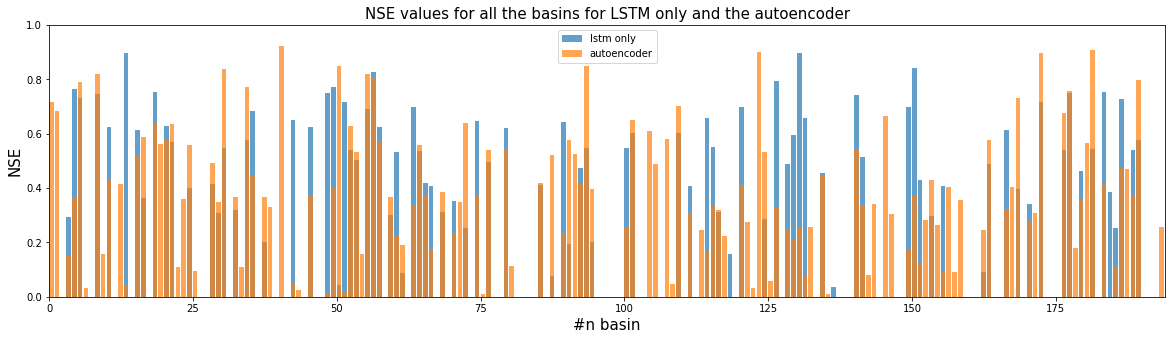

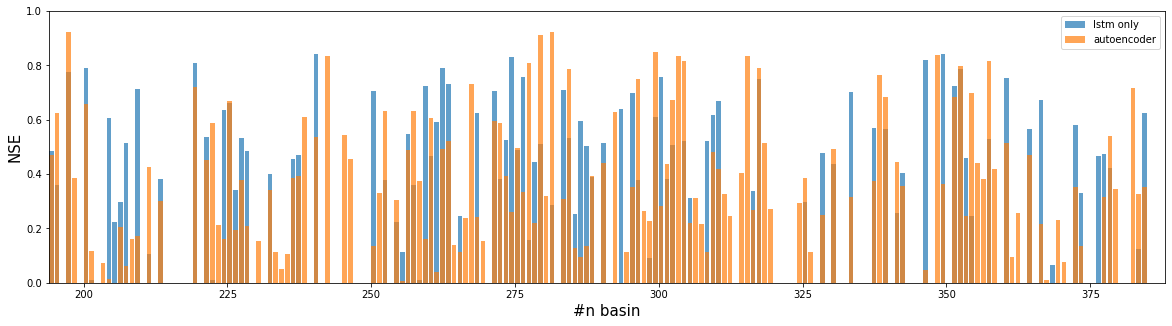

In [42]:
plt.figure(figsize=(20,5))
plt.xlabel('#n basin', fontsize = 15)
plt.ylabel("NSE", fontsize = 15)
plt.title("NSE values for all the basins for LSTM only and the autoencoder", fontsize = 15)

y1 = list(nse_collect1.values())
y2 = list(nse_collect2.values())
x = range(len(nse_collect2.keys()))
plt.xlim(0,len(x)/2)

plt.bar(x[:int(len(x)/2)], y1[:int(len(x)/2)], label="lstm only",width = 0.8,align = 'edge',  alpha=0.7) #only the first 200 basins for space reasons ---> we can think about how to plot all the values
plt.bar(x[:int(len(x)/2)], y2[:int(len(x)/2)], label="autoencoder",width = 0.8,align = 'edge', alpha=0.7)
plt.legend(loc="best")
plt.ylim(0,1)
plt.show()

plt.figure(figsize=(20,5))
plt.xlabel('#n basin', fontsize = 15)
plt.ylabel("NSE", fontsize = 15)
#plt.title("NSE values for all the basins for LSTM only and the autoencoder")

y1 = list(nse_collect1.values())
y2 = list(nse_collect2.values())
x = range(len(nse_collect2.keys()))
plt.xlim(len(x)/2, len(x))

plt.bar(x[int(len(x)/2):], y1[int(len(x)/2):], label="lstm only",width = 0.8,align = 'edge',  alpha=0.7) #only the first 200 basins for space reasons ---> we can think about how to plot all the values
plt.bar(x[int(len(x)/2):], y2[int(len(x)/2):], label="autoencoder",width = 0.8,align = 'edge', alpha=0.7)
plt.legend(loc="best")
plt.ylim(0,1)
plt.show()
#plt.xticks(x, list(nse_collect2.keys()))



At first sight, it may not be clear to conclude that using the Autoencoder the NSE coefficienty has increased for all the basins, but looking more in depth, it can be observed that for several basins only the orange discharge bar is shown: it means that for that particular basins the NSE value of the LSTM is negative, while the NSE value of the Autoencoder is positive. This is a very important result because it means that the Autoencoder is able to return good predictions of basins that are unpredictable with the LSTM alone.

In the following plot the loss values of all the single basins contained in the test set are shown. As the NSE coefficient, the loss value is calculated over all the years available for each basin of the test set.

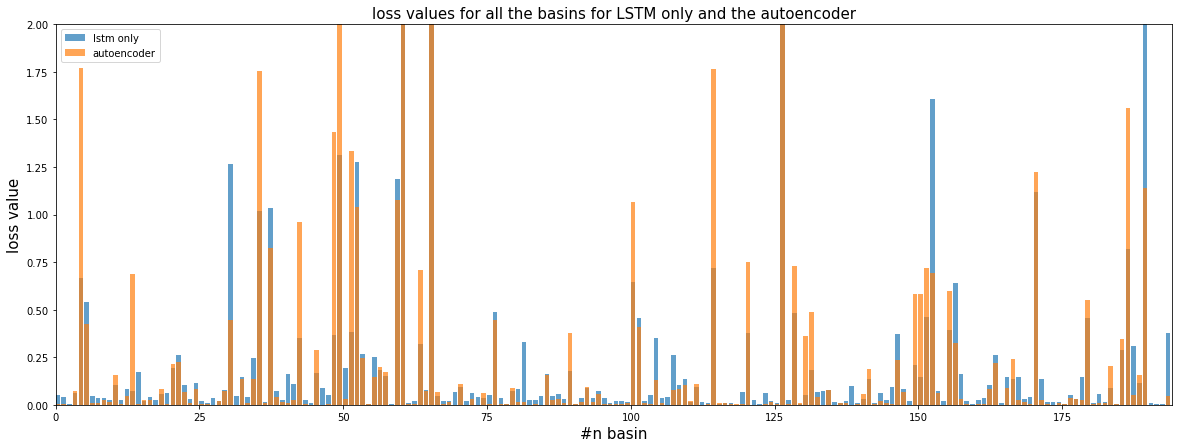

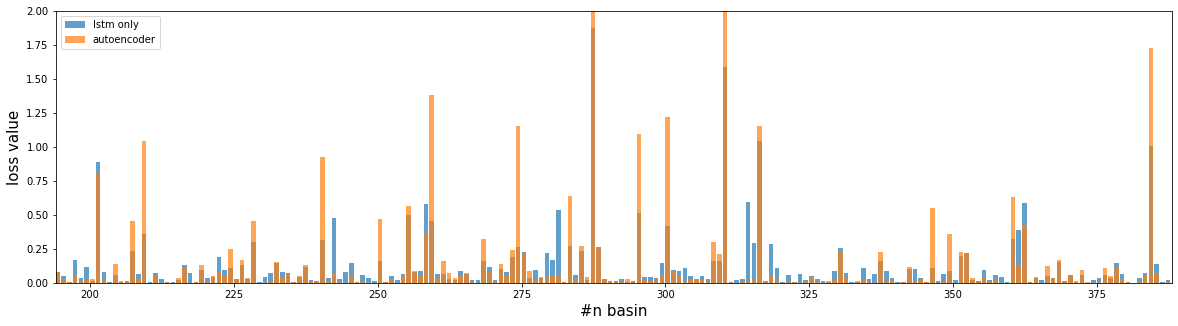

In [43]:
plt.figure(figsize=(20,7))
plt.xlabel('#n basin', fontsize = 15)
plt.ylabel("loss value", fontsize = 15)
plt.title("loss values for all the basins for LSTM only and the autoencoder", fontsize = 15)

loss1 = list(loss_collect1.values())
loss2 = list(loss_collect2.values())
x = range(len(loss_collect1.keys()))
plt.xlim(0,len(x)/2)

plt.bar(x[:int(len(x)/2)], loss1[:int(len(x)/2)], label="lstm only",width = 0.8,align = 'edge',  alpha=0.7) #only the first 200 basins for space reasons ---> we can think about how to plot all the values
plt.bar(x[:int(len(x)/2)], loss2[:int(len(x)/2)], label="autoencoder",width = 0.8,align = 'edge', alpha=0.7)
plt.legend(loc="best")
plt.ylim(0,2)
plt.show()


plt.figure(figsize=(20,5))
plt.xlabel('#n basin', fontsize = 15)
plt.ylabel("loss value", fontsize = 15)
#plt.title("NSE values for all the basins for LSTM only and the autoencoder")
plt.xlim(len(x)/2, len(x))

plt.bar(x[int(len(x)/2):], loss1[int(len(x)/2):], label="lstm only",width = 0.8,align = 'edge',  alpha=0.7) #only the first 200 basins for space reasons ---> we can think about how to plot all the values
plt.bar(x[int(len(x)/2):], loss2[int(len(x)/2):], label="autoencoder",width = 0.8,align = 'edge', alpha=0.7)
plt.legend(loc="best")
plt.ylim(0,2)
plt.show()
#plt.xticks(x, list(nse_collect2.keys()))


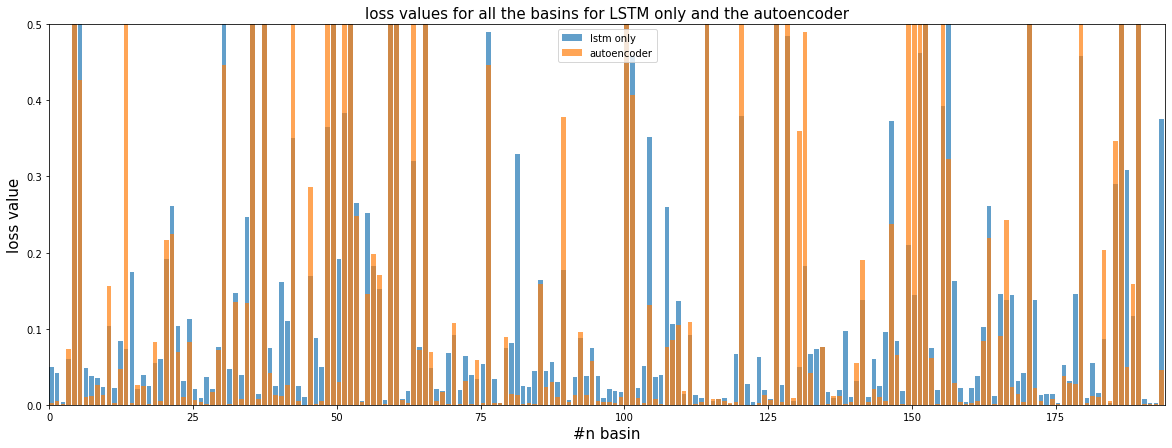

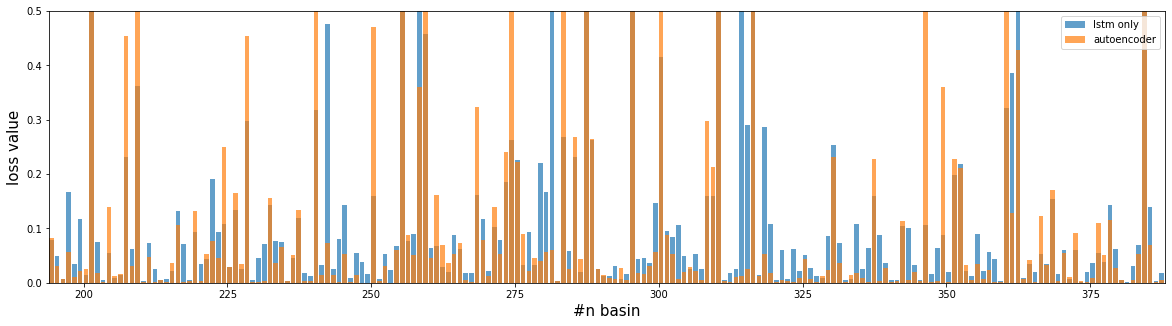

In [44]:
plt.figure(figsize=(20,7))
plt.xlabel('#n basin', fontsize = 15)
plt.ylabel("loss value", fontsize = 15)
plt.title("loss values for all the basins for LSTM only and the autoencoder", fontsize = 15)

loss1 = list(loss_collect1.values())
loss2 = list(loss_collect2.values())
x = range(len(loss_collect1.keys()))
plt.xlim(0,len(x)/2)

plt.bar(x[:int(len(x)/2)], loss1[:int(len(x)/2)], label="lstm only",width = 0.8,align = 'edge',  alpha=0.7) #only the first 200 basins for space reasons ---> we can think about how to plot all the values
plt.bar(x[:int(len(x)/2)], loss2[:int(len(x)/2)], label="autoencoder",width = 0.8,align = 'edge', alpha=0.7)
plt.legend(loc="best")
plt.ylim(0,0.5)
plt.show()


plt.figure(figsize=(20,5))
plt.xlabel('#n basin', fontsize = 15)
plt.ylabel("loss value", fontsize = 15)
#plt.title("NSE values for all the basins for LSTM only and the autoencoder")
plt.xlim(len(x)/2, len(x))

plt.bar(x[int(len(x)/2):], loss1[int(len(x)/2):], label="lstm only",width = 0.8,align = 'edge',  alpha=0.7) #only the first 200 basins for space reasons ---> we can think about how to plot all the values
plt.bar(x[int(len(x)/2):], loss2[int(len(x)/2):], label="autoencoder",width = 0.8,align = 'edge', alpha=0.7)
plt.legend(loc="best")
plt.ylim(0,0.5)
plt.show()
#plt.xticks(x, list(nse_collect2.keys()))


The zoom on the smaller loss values shows how the autoencoder has worked better in reducing the loss of the basins that had aldready a plausible loss value ($\text{loss}<0.5$) for the LSTM, instead of correcting the loss of those basins which have very high loss values.

By looking at the following dataframe it is even more easy to understand how the Autoencoder has reduced the loss values. 
First, a general dataframe for collecting the loss values of both the basins is created and general considerations about the percentage difference between the two loss are made. Then, the same considerations are made about arid, humid and average basins, previously identificated using the aridity parameter:
* $\text{arid}$ if $\text{aridity} \geq 1.5$
* $\text{average}$ if $0.7 < \text{aridity} < 1.5$
* $\text{humid}$ if $\text{aridity} \leq 0.7$

In [45]:
loss1 = np.array(loss1)
loss2 = np.array(loss2)

df = pd.DataFrame(data = {'Aridity':test_aridity,'loss LSTM':loss1, 'loss Autoencoder':loss2, 'difference':(loss2-loss1)/abs(loss1)*100}, index = list(loss_collect2.keys()))   #a dataframe to collect all data
print("General considerations:")
df_loss = df[df['difference']<0]
print(f"The Encoder has decreased the loss value for the {round((len(df_loss)/len(df))*100,2)}% of basins in the test set.")
df_loss2 = df[df['difference']>50]
print(f"The Encoder has increased more than 50% the loss value for the {round((len(df_loss2)/len(df))*100,2)}% of basins in the test set.")
df_loss3 = df[df['difference']<-50]
print(f"The Encoder has decreased more than 50% the loss value for the {round((len(df_loss3)/len(df))*100,2)}% of basins in the test set.")
print("------------------")
print("ARID BASINS")
df_arid = df[df['Aridity']>=1.5]
df_arid1 = df_arid[df_arid['difference']<0]
print(f"The Encoder has decreased the loss value for the {round((len(df_arid1)/len(df_arid))*100,2)}% of arid basins in the test set.")
df_arid2 = df_arid[df_arid['difference']>50]
print(f"The Encoder has increased more than 50% the loss value for the {round((len(df_arid2)/len(df_arid))*100,2)}% of arid basins in the test set.")
df_arid3 = df_arid[df_arid['difference']<-50]
print(f"The Encoder has decreased more than 50% the loss value for the {round((len(df_arid3)/len(df_arid))*100,2)}% of arid basins in the test set.")
print("------------------")
print("HUMID BASINS")
df_humid = df[df['Aridity']<=0.7]
df_humid1 = df_humid[df_humid['difference']<0]
print(f"The Encoder has decreased the loss value for the {round((len(df_humid1)/len(df_humid))*100,2)}% of humid basins in the test set.")
df_humid2 = df_humid[df_humid['difference']>50]
print(f"The Encoder has increased more than 50% the loss value for the {round((len(df_humid2)/len(df_humid))*100,2)}% of humid basins in the test set.")
df_humid3 = df_humid[df_humid['difference']<-50]
print(f"The Encoder has decreased more than 50% the loss value for the {round((len(df_humid3)/len(df_humid))*100,2)}% of humid basins in the test set.")
print("------------------")
print("AVERAGE BASINS")
df_average = df[(df['Aridity']<1.5)&(df['Aridity']>0.7)]
df_average1 = df_average[df_average['difference']<0]
print(f"The Encoder has decreased the loss value for the {round((len(df_average1)/len(df_average))*100,2)}% of average basins in the test set.")
df_average2 = df_average[df_average['difference']>50]
print(f"The Encoder has increased more than 50% the loss value for the {round((len(df_average2)/len(df_average))*100,2)}% of average basins in the test set.")
df_average3 = df_average[df_average['difference']<-50]
print(f"The Encoder has decreased more than 50% the loss value for the {round((len(df_average3)/len(df_average))*100,2)}% of average basins in the test set.")

General considerations:
The Encoder has decreased the loss value for the 69.07% of basins in the test set.
The Encoder has increased more than 50% the loss value for the 16.75% of basins in the test set.
The Encoder has decreased more than 50% the loss value for the 45.36% of basins in the test set.
------------------
ARID BASINS
The Encoder has decreased the loss value for the 75.71% of arid basins in the test set.
The Encoder has increased more than 50% the loss value for the 15.71% of arid basins in the test set.
The Encoder has decreased more than 50% the loss value for the 58.57% of arid basins in the test set.
------------------
HUMID BASINS
The Encoder has decreased the loss value for the 65.25% of humid basins in the test set.
The Encoder has increased more than 50% the loss value for the 17.8% of humid basins in the test set.
The Encoder has decreased more than 50% the loss value for the 43.22% of humid basins in the test set.
------------------
AVERAGE BASINS
The Encoder has 

Similarly, the NSE coefficient for each basins are collected into a dataframe and some general and specific consideration are made.

In [46]:
y1 = np.array(y1)
y2 = np.array(y2)
df_nse = pd.DataFrame(data = {'Aridity':test_aridity,'NSE LSTM':y1, 'NSE Autoencoder':y2, 'difference':(y2-y1)/abs(y1)*100}, index = list(loss_collect2.keys()))   #a dataframe to collect all data
print("General considerations:")
df_nse1 = df_nse[df_nse['difference']>0]
print(f"The Encoder has increased the NSE value of the predictions for the {round((len(df_nse1)/len(df_nse))*100,2)}% of basins in the test set.")
df_nse2 = df_nse[df_nse['difference']>50]
print(f"The Encoder has increased more than 50% the NSE value of the predictions for the {round((len(df_nse2)/len(df_nse))*100,2)}% of basins in the test set.")
df_nse3 = df_nse[df_nse['difference']<-50]
print(f"The Encoder has decreased more than 50% the NSE value of the predictions for the {round((len(df_nse3)/len(df_nse))*100,2)}% of basins in the test set.")
print("------------------")
print("ARID BASINS")
df_arid = df_nse[df_nse['Aridity']>=1.5]
df_arid1 = df_arid[df_arid['difference']>0]
print(f"The Encoder has increased the NSE value of the predictions for the {round((len(df_arid1)/len(df_arid))*100,2)}% of arid basins in the test set.")
df_arid2 = df_arid[df_arid['difference']>50]
print(f"The Encoder has increased more than 50% the NSE value of the predictions for the {round((len(df_arid2)/len(df_arid))*100,2)}% of arid basins in the test set.")
df_arid3 = df_arid[df_arid['difference']<-50]
print(f"The Encoder has decreased more than 50% the NSE value of the predictions for the {round((len(df_arid3)/len(df_arid))*100,2)}% of arid basins in the test set.")
print("------------------")
print("HUMID BASINS")
df_humid = df_nse[df_nse['Aridity']<=0.7]
df_humid1 = df_humid[df_humid['difference']>0]
print(f"The Encoder has increased the NSE value of the predictions for the {round((len(df_humid1)/len(df_humid))*100,2)}% of humid basins in the test set.")
df_humid2 = df_humid[df_humid['difference']>50]
print(f"The Encoder has increased more than 50% the NSE value of the predictions for the {round((len(df_humid2)/len(df_humid))*100,2)}% of humid basins in the test set.")
df_humid3 = df_humid[df_humid['difference']<-50]
print(f"The Encoder has decreased more than 50% the NSE value of the predictions for the {round((len(df_humid3)/len(df_humid))*100,2)}% of humid basins in the test set.")
print("------------------")
print("AVERAGE BASINS")
df_average = df_nse[(df_nse['Aridity']<1.5)&(df_nse['Aridity']>0.7)]
df_average1 = df_average[df_average['difference']>0]
print(f"The Encoder has increased the NSE value of the predictions for the {round((len(df_average1)/len(df_average))*100,2)}% of average basins in the test set.")
df_average2 = df_average[df_average['difference']>50]
print(f"The Encoder has increased more than 50% the NSE value of the predictions for the {round((len(df_average2)/len(df_average))*100,2)}% of average basins in the test set.")
df_average3 = df_average[df_average['difference']<-50]
print(f"The Encoder has decreased more than 50% the NSE value of the predictions for the {round((len(df_average3)/len(df_average))*100,2)}% of average basins in the test set.")


General considerations:
The Encoder has increased the NSE value of the predictions for the 69.07% of basins in the test set.
The Encoder has increased more than 50% the NSE value of the predictions for the 56.7% of basins in the test set.
The Encoder has decreased more than 50% the NSE value of the predictions for the 13.92% of basins in the test set.
------------------
ARID BASINS
The Encoder has increased the NSE value of the predictions for the 75.71% of arid basins in the test set.
The Encoder has increased more than 50% the NSE value of the predictions for the 65.71% of arid basins in the test set.
The Encoder has decreased more than 50% the NSE value of the predictions for the 11.43% of arid basins in the test set.
------------------
HUMID BASINS
The Encoder has increased the NSE value of the predictions for the 65.25% of humid basins in the test set.
The Encoder has increased more than 50% the NSE value of the predictions for the 55.93% of humid basins in the test set.
The Encod

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning:

invalid value encountered in subtract



It can be observed that both for the loss and the NSE coefficient the best improvements are with the arid basins. An explanation for this phenomenon could be found in the ability of the Encoder to learn more easily the catchment features from the arid basins, in addiction it is evident that the LSTM alone is able to learn better from the humid basins because of the high discharge levels.

The values of the NSE are able to evaluate the ability of a model to predict the discharge of a given basin. As suggested in the first plot of this section, the Autoencoder is able for some basins to obtain a positive NSE value when the NSE value of the LSTM alone on the same basin return a negative value. It is then able to predict discharge from basins that are classified not predictable for the LSTM alone.

In [47]:
print("General considerations:")
df_good_auto = df_nse[df_nse['NSE Autoencoder']>0]
df_bad_lstm = df_nse[df_nse['NSE LSTM']<0]
df_improvement = df_good_auto[df_good_auto['NSE LSTM']<0]
print(f"The Encoder has changed {len(df_improvement)} basins that with the lstm had a negative nse, it means {round((len(df_improvement)/len(df_bad_lstm))*100,2)}% of basins that had negative nse values for the lstm.")
print(f"The positive NSEs of the autoencoder are {round((len(df_improvement)/len(df_good_auto))*100,2)}%  from basins that improved from negative in the lstm to positive")

print("------------------")
print("ARID BASINS")
df_arid_good_auto = df_arid[df_arid['NSE Autoencoder']>0]
df_arid_bad_lstm = df_arid[df_arid['NSE LSTM']<0]
df_improvement_arid = df_arid_good_auto[df_arid_good_auto['NSE LSTM']<0]
print(f"The Encoder has changed {len(df_improvement_arid)} arid basins that with the lstm had a negative nse, it means {round((len(df_improvement_arid)/len(df_arid_bad_lstm))*100,2)}% of basins that had negative nse values for the lstm.")
print(f"The positive NSEs of the autoencoder are {round((len(df_improvement_arid)/len(df_arid_good_auto))*100,2)}%  from arid basins that improved from negative in the lstm to positive")

print("------------------")
print("HUMID BASINS")
df_humid_good_auto = df_humid[df_humid['NSE Autoencoder']>0]
df_humid_bad_lstm = df_humid[df_humid['NSE LSTM']<0]
df_improvement_humid = df_humid_good_auto[df_humid_good_auto['NSE LSTM']<0]
print(f"The Encoder has changed {len(df_improvement_humid)} humid basins that with the lstm had a negative nse, it means {round((len(df_improvement_humid)/len(df_humid_bad_lstm))*100,2)}% of basins that had negative nse values for the lstm.")
print(f"The positive NSEs of the autoencoder are {round((len(df_improvement_humid)/len(df_humid_good_auto))*100,2)}%  from humid basins that improved from negative in the lstm to positive")

print("------------------")
print("AVERAGE BASINS")
df_average_good_auto = df_average[df_average['NSE Autoencoder']>0]
df_average_bad_lstm = df_average[df_average['NSE LSTM']<0]
df_improvement_average = df_average_good_auto[df_average_good_auto['NSE LSTM']<0]
print(f"The Encoder has changed {len(df_improvement_average)} humid basins that with the lstm had a negative nse, it means {round((len(df_improvement_average)/len(df_average_bad_lstm))*100,2)}% of basins that had negative nse values for the lstm.")
print(f"The positive NSEs of the autoencoder are {round((len(df_improvement_average)/len(df_average_good_auto))*100,2)}%  from humid basins that improved from negative in the lstm to positive")


General considerations:
The Encoder has changed 89 basins that with the lstm had a negative nse, it means 44.06% of basins that had negative nse values for the lstm.
The positive NSEs of the autoencoder are 33.21%  from basins that improved from negative in the lstm to positive
------------------
ARID BASINS
The Encoder has changed 18 arid basins that with the lstm had a negative nse, it means 45.0% of basins that had negative nse values for the lstm.
The positive NSEs of the autoencoder are 38.3%  from arid basins that improved from negative in the lstm to positive
------------------
HUMID BASINS
The Encoder has changed 26 humid basins that with the lstm had a negative nse, it means 40.0% of basins that had negative nse values for the lstm.
The positive NSEs of the autoencoder are 33.33%  from humid basins that improved from negative in the lstm to positive
------------------
AVERAGE BASINS
The Encoder has changed 45 humid basins that with the lstm had a negative nse, it means 46.39% 

The best results of this project could be found into the previously presented basins, for which the Autoencoder is able to return some good predictions even though the LSTM failed. 
In the following plot the three best predictions in this sense are presented, chosen randomly among the arid, humid and average basins.

In [48]:
df_improvement_arid_best = df_improvement_arid[df_improvement_arid['NSE Autoencoder']>0.7]
df_improvement_humid_best = df_improvement_humid[df_improvement_humid['NSE Autoencoder']>0.7]
df_improvement_average_best = df_improvement_average[df_improvement_average['NSE Autoencoder']>0.7]

In [49]:
random.seed(300622)
#Now I want to plot the results for only 1 basin of each kind. I choose them randomly and then I keep the choice for the autoencoder's results.
arid_one_code = random.choice(df_improvement_arid_best.index)
humid_one_code = random.choice(df_improvement_humid_best.index)
average_one_code = random.choice(df_improvement_average_best.index)
print(f"The basins chosen are: arid = {arid_one_code}, humid = {humid_one_code}, average = {average_one_code}")

#Extracting index for all the years in the test set for the three basins
index_arid_one = [i for i, n in enumerate(basins_order) if n == arid_one_code]
index_humid_one = [i for i, n in enumerate(basins_order) if n == humid_one_code]
index_average_one = [i for i, n in enumerate(basins_order) if n == average_one_code]

The basins chosen are: arid = 5291000.0, humid = 8271000.0, average = 6479438.0


LSTM: Predictions with less than 10% error are 7 out of 7, it means 100.0%.
Autoencoder: Predictions with less than 10% error are 7 out of 7, it means 100.0%.


,Q labels,Predictions LSTM,Error LSTM (%),Predictions Autoencoder,Error Autoencoder (%)
1981-09-24,0.673537,0.654099,2.885910,0.674002,0.068991
1981-09-25,0.673604,0.650042,3.497930,0.674430,0.122615
1981-09-26,0.673738,0.652337,3.176369,0.673645,0.013686
1981-09-27,0.673604,0.655971,2.617625,0.673575,0.004256
1981-09-28,0.673537,0.654453,2.833468,0.673384,0.022672
1981-09-29,0.673604,0.652384,3.150171,0.673474,0.019281
1981-09-30,0.673738,0.659676,2.087099,0.674359,0.092290


LSTM: Predictions with less than 10% error are 7 out of 7, it means 100.0%.
Autoencoder: Predictions with less than 10% error are 7 out of 7, it means 100.0%.


,Q labels,Predictions LSTM,Error LSTM (%),Predictions Autoencoder,Error Autoencoder (%)
1982-09-24,0.673671,0.678921,0.779345,0.675947,0.337860
1982-09-25,0.673738,0.676611,0.426552,0.674598,0.127775
1982-09-26,0.673671,0.658119,2.308517,0.675216,0.229440
1982-09-27,0.673537,0.666770,1.004745,0.674840,0.193388
1982-09-28,0.673470,0.658724,2.189530,0.675269,0.267087
1982-09-29,0.673470,0.664859,1.278570,0.675263,0.266237
1982-09-30,0.673470,0.667185,0.933290,0.675373,0.282584


LSTM: Predictions with less than 10% error are 7 out of 7, it means 100.0%.
Autoencoder: Predictions with less than 10% error are 7 out of 7, it means 100.0%.


,Q labels,Predictions LSTM,Error LSTM (%),Predictions Autoencoder,Error Autoencoder (%)
1983-09-24,0.673537,0.678015,0.664774,0.675770,0.331458
1983-09-25,0.673604,0.673972,0.054658,0.674218,0.091220
1983-09-26,0.673537,0.651188,3.318110,0.674672,0.168477
1983-09-27,0.673604,0.657044,2.458412,0.674271,0.099060
1983-09-28,0.673738,0.664102,1.430096,0.676294,0.379407
1983-09-29,0.673537,0.680212,0.991064,0.675906,0.351706
1983-09-30,0.673804,0.708559,5.157953,0.675590,0.264955


LSTM: Predictions with less than 10% error are 7 out of 7, it means 100.0%.
Autoencoder: Predictions with less than 10% error are 7 out of 7, it means 100.0%.


,Q labels,Predictions LSTM,Error LSTM (%),Predictions Autoencoder,Error Autoencoder (%)
1984-09-24,0.676812,0.672230,0.677057,0.681592,0.706251
1984-09-25,0.677347,0.682077,0.698302,0.684878,1.111853
1984-09-26,0.676679,0.662899,2.036329,0.682805,0.905390
1984-09-27,0.678417,0.647361,4.577620,0.682347,0.579365
1984-09-28,0.678751,0.653371,3.739259,0.684511,0.848708
1984-09-29,0.676812,0.650243,3.925592,0.682405,0.826330
1984-09-30,0.676144,0.647983,4.164967,0.677869,0.255108


LSTM: Predictions with less than 10% error are 7 out of 7, it means 100.0%.
Autoencoder: Predictions with less than 10% error are 7 out of 7, it means 100.0%.


,Q labels,Predictions LSTM,Error LSTM (%),Predictions Autoencoder,Error Autoencoder (%)
1985-09-24,0.676010,0.723930,7.088595,0.694283,2.702986
1985-09-25,0.677280,0.726361,7.246677,0.695216,2.648220
1985-09-26,0.676344,0.712485,5.343567,0.695219,2.790738
1985-09-27,0.675743,0.680071,0.640491,0.695048,2.856934
1985-09-28,0.675542,0.661965,2.009817,0.697367,3.230767
1985-09-29,0.675409,0.687092,1.729775,0.695044,2.907159
1985-09-30,0.677548,0.686684,1.348378,0.697022,2.874317


LSTM: Predictions with less than 10% error are 3 out of 7, it means 42.86%.
Autoencoder: Predictions with less than 10% error are 7 out of 7, it means 100.0%.


,Q labels,Predictions LSTM,Error LSTM (%),Predictions Autoencoder,Error Autoencoder (%)
1986-09-24,0.755019,0.935394,23.890102,0.760030,0.663679
1986-09-25,0.747667,0.909048,21.584660,0.754690,0.939327
1986-09-26,0.746998,0.901652,20.703320,0.764228,2.306474
1986-09-27,0.757693,0.849165,12.072467,0.763297,0.739578
1986-09-28,0.757025,0.774536,2.313199,0.765975,1.182346
1986-09-29,0.738977,0.802286,8.567164,0.758429,2.632276
1986-09-30,0.728950,0.785997,7.825886,0.765802,5.055398


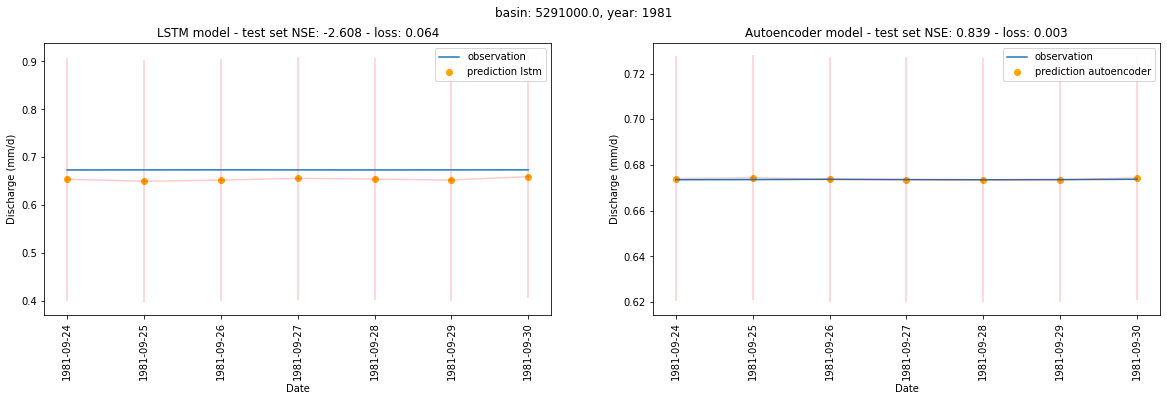

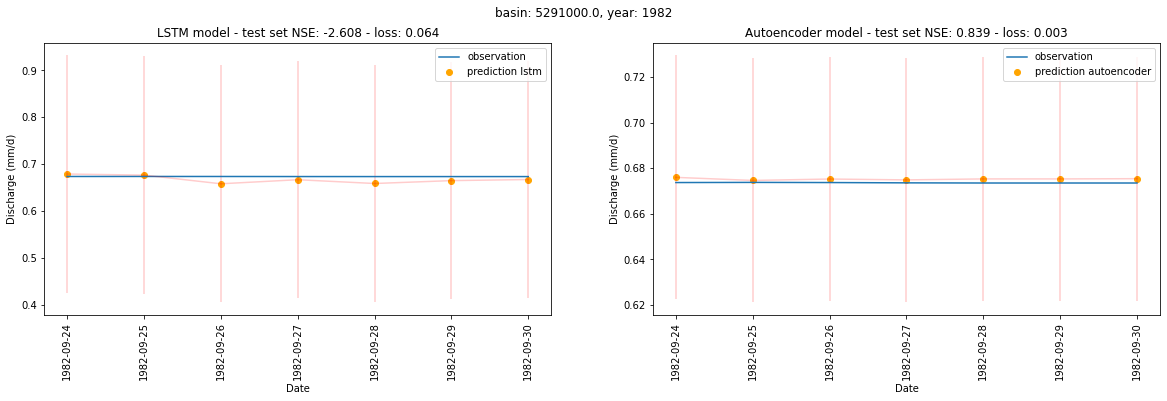

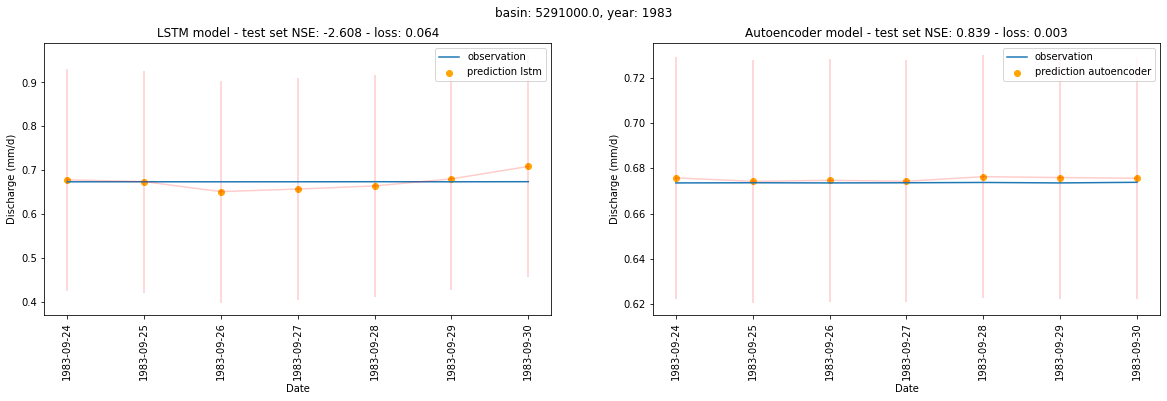

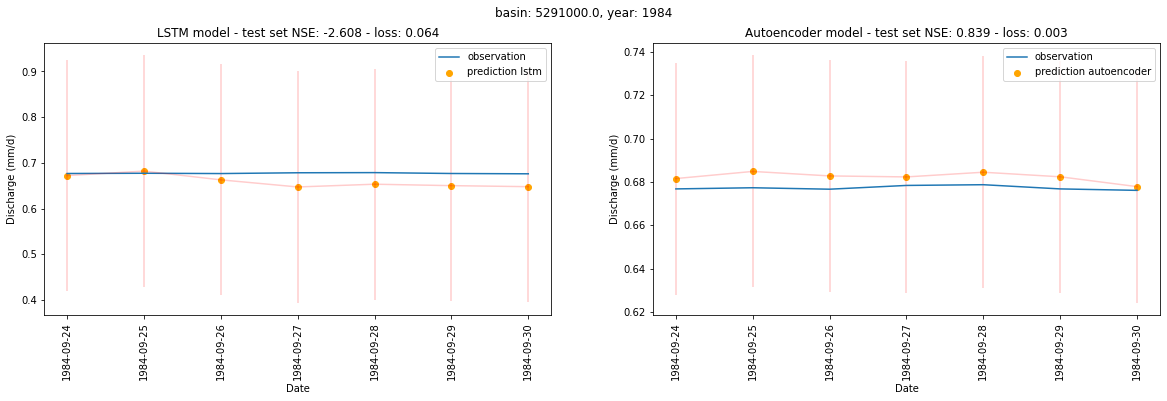

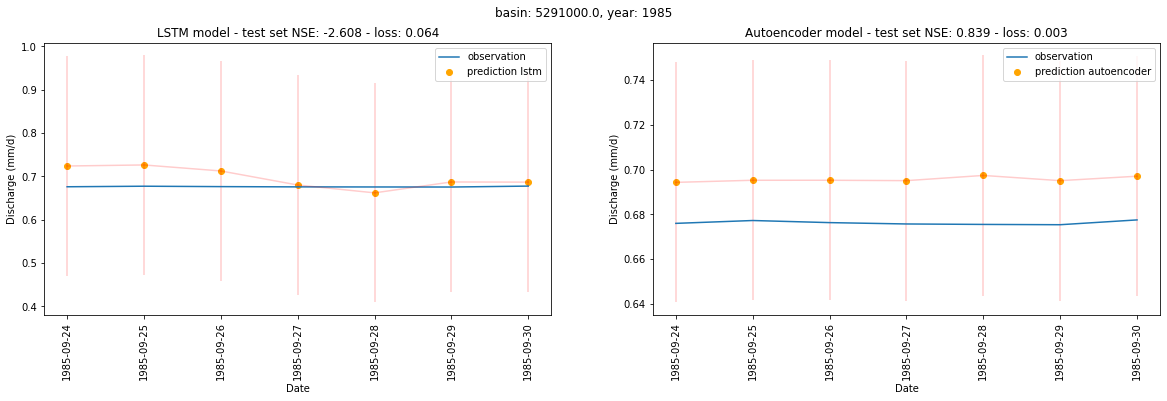

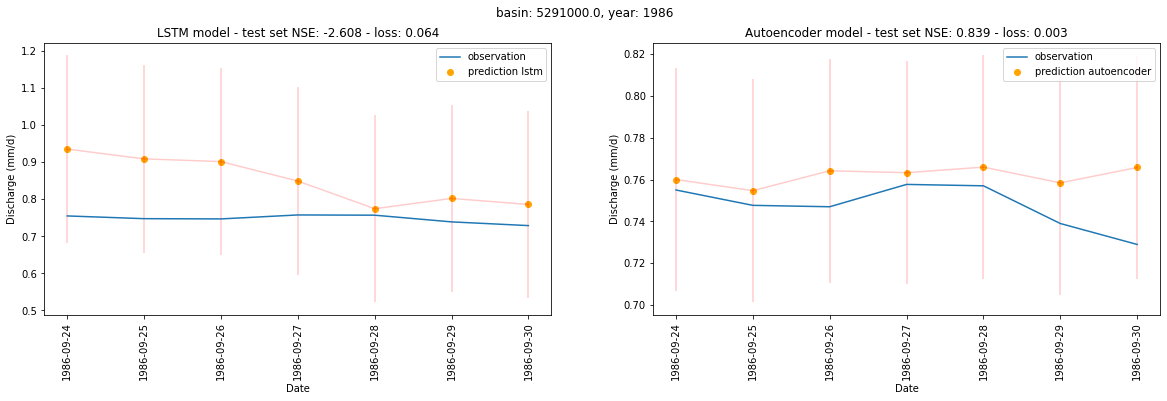

In [50]:
#last 7 days for an arid random basin
for index in index_arid_one:
  plot(index, y_pred1_rec, y_pred2_rec)

It can be observed that the predictions made by the LSTM are apparently good, and the loss very small, then the poor NSE values does not seem justified. However, the NSE formula returns the ability of the model to be a better predictor of the discharge than the mean value of the discharge's observations. In the case of arid basins we have an almost flat distribution of the discharge over a week, then it is not easy for a model to be a better estimator of the discharge than the mean value of an almost constant trend. The results of the Autoencoder in this case are considerables.

LSTM: Predictions with less than 10% error are 7 out of 7, it means 100.0%.
Autoencoder: Predictions with less than 10% error are 7 out of 7, it means 100.0%.


,Q labels,Predictions LSTM,Error LSTM (%),Predictions Autoencoder,Error Autoencoder (%)
2005-09-24,0.891348,0.863682,3.103817,0.897841,0.728485
2005-09-25,0.891348,0.868192,2.597829,0.916319,2.801563
2005-09-26,0.891348,0.878758,1.412447,0.908121,1.881816
2005-09-27,0.900690,0.876086,2.731595,0.901903,0.134703
2005-09-28,0.896019,0.851640,4.952824,0.910772,1.646557
2005-09-29,0.882006,0.814387,7.666481,0.915640,3.813348
2005-09-30,0.882006,0.936063,6.128900,0.898856,1.910486


LSTM: Predictions with less than 10% error are 3 out of 7, it means 42.86%.
Autoencoder: Predictions with less than 10% error are 6 out of 7, it means 85.71%.


,Q labels,Predictions LSTM,Error LSTM (%),Predictions Autoencoder,Error Autoencoder (%)
2006-09-24,1.643376,2.183536,32.868858,1.466858,10.741205
2006-09-25,1.596667,1.903243,19.201010,1.458718,8.639773
2006-09-26,1.549957,1.918083,23.750767,1.423847,8.136322
2006-09-27,1.503247,1.508856,0.373112,1.442372,4.049580
2006-09-28,1.456537,1.495643,2.684862,1.452701,0.263367
2006-09-29,1.409827,1.544107,9.524562,1.424457,1.037705
2006-09-30,1.409827,1.566849,11.137661,1.445559,2.534455


LSTM: Predictions with less than 10% error are 0 out of 7, it means 0.0%.
Autoencoder: Predictions with less than 10% error are 0 out of 7, it means 0.0%.


,Q labels,Predictions LSTM,Error LSTM (%),Predictions Autoencoder,Error Autoencoder (%)
2007-09-24,0.942728,1.502074,59.332664,1.097251,16.391035
2007-09-25,0.942728,1.396882,48.174370,1.092496,15.886582
2007-09-26,0.942728,1.305748,38.507290,1.089453,15.563766
2007-09-27,0.938057,1.193360,27.216118,1.085581,15.726471
2007-09-28,0.933387,1.205190,29.120111,1.095868,17.407713
2007-09-29,0.928715,1.202811,29.513443,1.096050,18.017849
2007-09-30,0.928715,1.100269,18.472113,1.097443,18.167875


LSTM: Predictions with less than 10% error are 1 out of 7, it means 14.29%.
Autoencoder: Predictions with less than 10% error are 6 out of 7, it means 85.71%.


,Q labels,Predictions LSTM,Error LSTM (%),Predictions Autoencoder,Error Autoencoder (%)
2008-09-24,1.129568,1.317219,16.612682,1.124246,0.471183
2008-09-25,1.082858,1.384380,27.845016,1.141505,5.415982
2008-09-26,1.082858,1.072270,0.977754,1.132991,4.629681
2008-09-27,1.082858,1.200945,10.905072,1.123663,3.768267
2008-09-28,1.129568,2.531533,124.115158,1.124139,0.480639
2008-09-29,1.316407,2.437455,85.159592,1.124148,14.604866
2008-09-30,1.129568,2.318678,105.271278,1.132118,0.225719


LSTM: Predictions with less than 10% error are 5 out of 7, it means 71.43%.
Autoencoder: Predictions with less than 10% error are 7 out of 7, it means 100.0%.


,Q labels,Predictions LSTM,Error LSTM (%),Predictions Autoencoder,Error Autoencoder (%)
2009-09-24,1.409827,1.556939,10.434731,1.306239,7.347549
2009-09-25,1.409827,1.346812,4.469738,1.307082,7.287786
2009-09-26,1.409827,1.419712,0.701172,1.281639,9.092489
2009-09-27,1.363117,1.269052,6.900784,1.276671,6.341816
2009-09-28,1.409827,1.180531,16.264135,1.282795,9.010444
2009-09-29,1.363117,1.253718,8.025681,1.302914,4.416582
2009-09-30,1.363117,1.257109,7.776893,1.326185,2.709439


LSTM: Predictions with less than 10% error are 6 out of 7, it means 85.71%.
Autoencoder: Predictions with less than 10% error are 7 out of 7, it means 100.0%.


,Q labels,Predictions LSTM,Error LSTM (%),Predictions Autoencoder,Error Autoencoder (%)
2010-09-24,1.082858,1.006456,7.055627,1.092926,0.929767
2010-09-25,1.082858,0.980382,9.463452,1.093664,0.997944
2010-09-26,1.036148,0.976984,5.709976,1.107254,6.862528
2010-09-27,1.036148,0.962276,7.129519,1.084049,4.622945
2010-09-28,1.036148,0.938473,9.426777,1.083111,4.532469
2010-09-29,1.036148,0.922839,10.935629,1.102921,6.444308
2010-09-30,1.036148,0.958945,7.450976,1.103874,6.536325


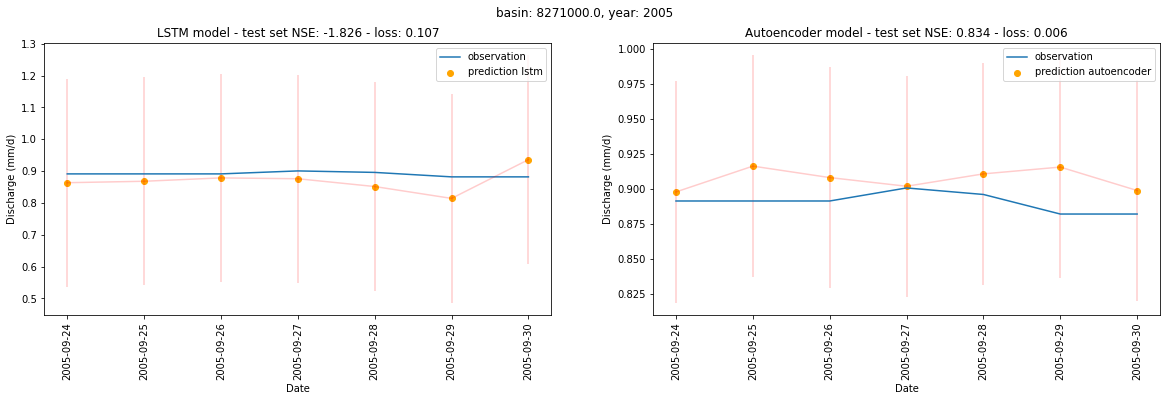

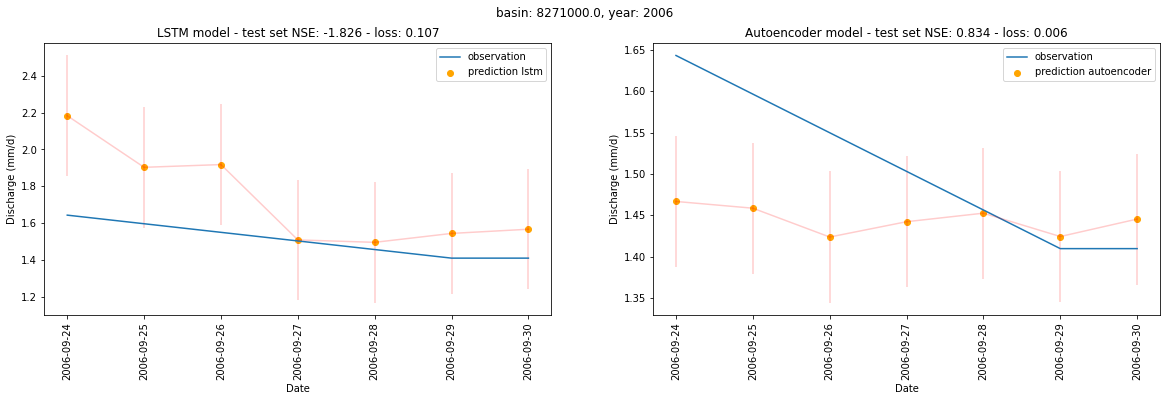

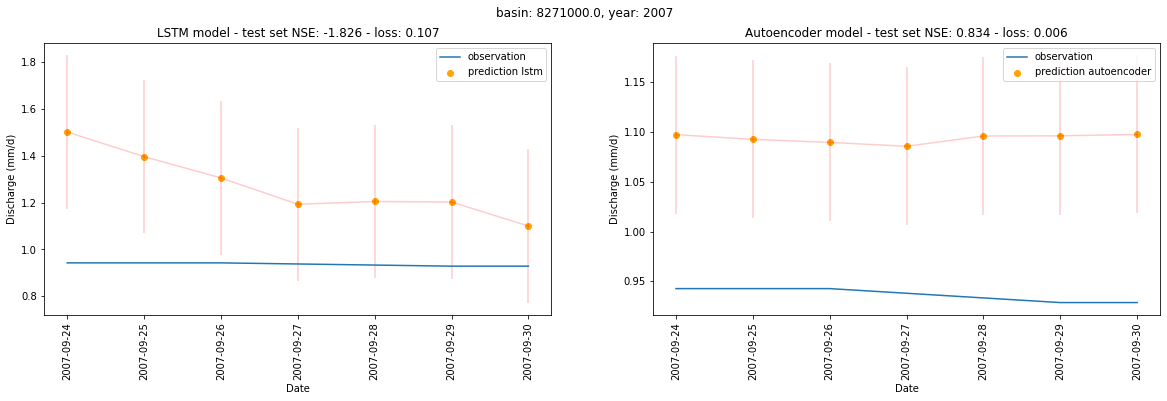

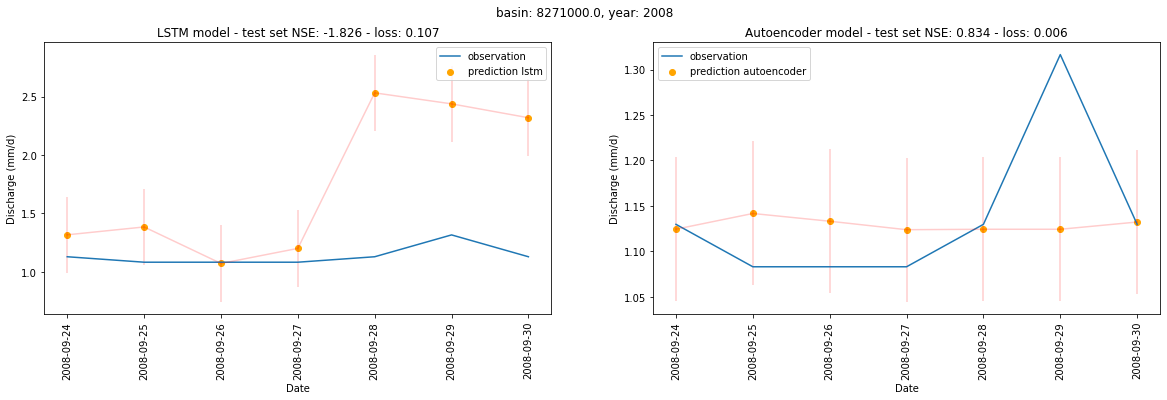

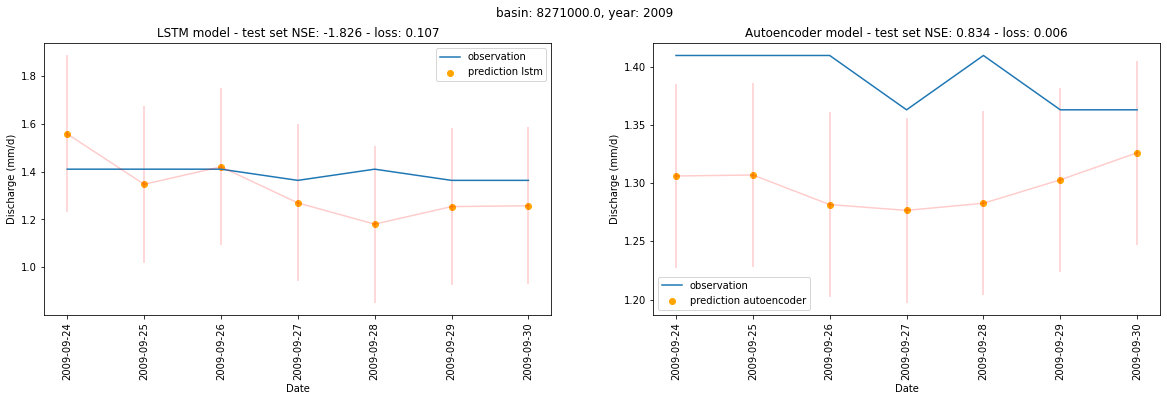

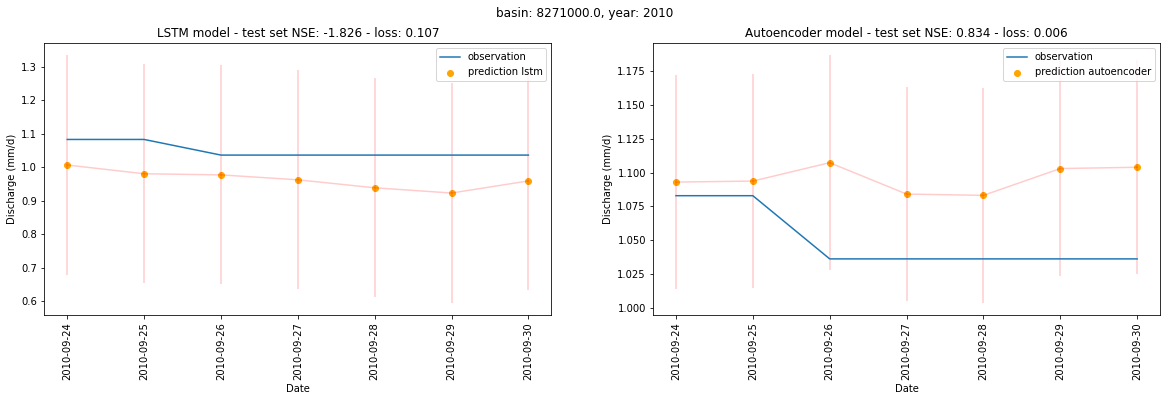

In [51]:
#last 7 days for an humid random basin
for index in index_humid_one:
  plot(index,  y_pred1_rec, y_pred2_rec)

For the humid basins the fluctuations of the discharges in a week are more important, therefore the percentage errors and the loss values are higher compared to the arid basins. The predictions of Autoencoder on the chosen basin are able to get closer to the true discharge values, this behaviour is evident by looking at the different shapes of the observed discharge into the two adjacent plots: the scales of the y-axis of the plots are very different.

LSTM: Predictions with less than 10% error are 7 out of 7, it means 100.0%.
Autoencoder: Predictions with less than 10% error are 7 out of 7, it means 100.0%.


,Q labels,Predictions LSTM,Error LSTM (%),Predictions Autoencoder,Error Autoencoder (%)
1993-09-24,0.706124,0.710683,0.645652,0.706394,0.038339
1993-09-25,0.706015,0.713731,1.092852,0.705782,0.033035
1993-09-26,0.706775,0.706980,0.028985,0.705582,0.168827
1993-09-27,0.706992,0.708550,0.220312,0.706222,0.108891
1993-09-28,0.706775,0.701949,0.682905,0.708012,0.174949
1993-09-29,0.706558,0.702020,0.642260,0.706702,0.020390
1993-09-30,0.706558,0.694253,1.741494,0.706119,0.062198


LSTM: Predictions with less than 10% error are 7 out of 7, it means 100.0%.
Autoencoder: Predictions with less than 10% error are 7 out of 7, it means 100.0%.


,Q labels,Predictions LSTM,Error LSTM (%),Predictions Autoencoder,Error Autoencoder (%)
1994-09-24,0.703095,0.688375,2.093588,0.708122,0.715100
1994-09-25,0.703073,0.685495,2.500160,0.709911,0.972650
1994-09-26,0.703051,0.688407,2.082933,0.706137,0.438846
1994-09-27,0.703051,0.685569,2.486553,0.708082,0.715568
1994-09-28,0.703051,0.683711,2.750923,0.707872,0.685760
1994-09-29,0.703040,0.682629,2.903232,0.706187,0.447594
1994-09-30,0.703051,0.684914,2.579811,0.707897,0.689202


LSTM: Predictions with less than 10% error are 7 out of 7, it means 100.0%.
Autoencoder: Predictions with less than 10% error are 7 out of 7, it means 100.0%.


,Q labels,Predictions LSTM,Error LSTM (%),Predictions Autoencoder,Error Autoencoder (%)
1995-09-24,0.708947,0.711706,0.389166,0.719591,1.501444
1995-09-25,0.707752,0.699175,1.211914,0.719729,1.692211
1995-09-26,0.707644,0.691691,2.254417,0.724023,2.314667
1995-09-27,0.707644,0.706382,0.178272,0.719671,1.699630
1995-09-28,0.707427,0.696295,1.573465,0.719008,1.637078
1995-09-29,0.707318,0.692135,2.146530,0.719941,1.784605
1995-09-30,0.707101,0.686753,2.877650,0.714554,1.054017


LSTM: Predictions with less than 10% error are 7 out of 7, it means 100.0%.
Autoencoder: Predictions with less than 10% error are 7 out of 7, it means 100.0%.


,Q labels,Predictions LSTM,Error LSTM (%),Predictions Autoencoder,Error Autoencoder (%)
1996-09-24,0.703105,0.694932,1.162430,0.710635,1.070917
1996-09-25,0.703127,0.684098,2.706375,0.710984,1.117440
1996-09-26,0.703171,0.687142,2.279481,0.709261,0.866126
1996-09-27,0.703171,0.688478,2.089488,0.710709,1.072072
1996-09-28,0.703236,0.690623,1.793481,0.709668,0.914603
1996-09-29,0.703301,0.694983,1.182667,0.708254,0.704229
1996-09-30,0.703409,0.691971,1.626141,0.710806,1.051515


LSTM: Predictions with less than 10% error are 7 out of 7, it means 100.0%.
Autoencoder: Predictions with less than 10% error are 7 out of 7, it means 100.0%.


,Q labels,Predictions LSTM,Error LSTM (%),Predictions Autoencoder,Error Autoencoder (%)
1997-09-24,0.702997,0.681574,3.047388,0.704850,0.263576
1997-09-25,0.703019,0.678627,3.469492,0.704083,0.151339
1997-09-26,0.703019,0.677590,3.617050,0.702839,0.025511
1997-09-27,0.703062,0.677828,3.589231,0.703772,0.100980
1997-09-28,0.703062,0.683431,2.792193,0.703840,0.110687
1997-09-29,0.703029,0.674897,4.001618,0.702651,0.053862
1997-09-30,0.703019,0.677010,3.699578,0.703050,0.004409


LSTM: Predictions with less than 10% error are 4 out of 7, it means 57.14%.
Autoencoder: Predictions with less than 10% error are 7 out of 7, it means 100.0%.


,Q labels,Predictions LSTM,Error LSTM (%),Predictions Autoencoder,Error Autoencoder (%)
1998-09-24,0.725667,0.885827,22.070755,0.749509,3.285576
1998-09-25,0.727838,0.858701,17.979687,0.751009,3.183456
1998-09-26,0.732181,0.873483,19.298737,0.751540,2.644001
1998-09-27,0.739781,0.766132,3.561932,0.753240,1.819326
1998-09-28,0.733267,0.763897,4.177180,0.754496,2.895195
1998-09-29,0.728924,0.746752,2.445828,0.751022,3.031544
1998-09-30,0.722410,0.737841,2.136102,0.750211,3.848442


LSTM: Predictions with less than 10% error are 7 out of 7, it means 100.0%.
Autoencoder: Predictions with less than 10% error are 7 out of 7, it means 100.0%.


,Q labels,Predictions LSTM,Error LSTM (%),Predictions Autoencoder,Error Autoencoder (%)
1993-09-24,0.704170,0.712543,1.189165,0.709024,0.689444
1993-09-25,0.704387,0.719020,2.077419,0.707677,0.467183
1993-09-26,0.704170,0.713846,1.374166,0.707404,0.459328
1993-09-27,0.704170,0.716520,1.753927,0.707018,0.404571
1993-09-28,0.704278,0.718138,1.967945,0.707648,0.478485
1993-09-29,0.704278,0.709108,0.685767,0.706914,0.374278
1993-09-30,0.704170,0.700898,0.464618,0.706564,0.339986


LSTM: Predictions with less than 10% error are 7 out of 7, it means 100.0%.
Autoencoder: Predictions with less than 10% error are 7 out of 7, it means 100.0%.


,Q labels,Predictions LSTM,Error LSTM (%),Predictions Autoencoder,Error Autoencoder (%)
1994-09-24,0.708621,0.758449,7.031651,0.709078,0.064498
1994-09-25,0.708187,0.753378,6.381327,0.709206,0.143965
1994-09-26,0.707427,0.741304,4.788751,0.711078,0.516141
1994-09-27,0.707101,0.701639,0.772398,0.709313,0.312859
1994-09-28,0.706558,0.716286,1.376767,0.708230,0.236661
1994-09-29,0.706558,0.719285,1.801287,0.711286,0.669086
1994-09-30,0.706232,0.711225,0.706884,0.710226,0.565450


LSTM: Predictions with less than 10% error are 4 out of 7, it means 57.14%.
Autoencoder: Predictions with less than 10% error are 7 out of 7, it means 100.0%.


,Q labels,Predictions LSTM,Error LSTM (%),Predictions Autoencoder,Error Autoencoder (%)
1995-09-24,0.730010,0.882155,20.841595,0.735123,0.700419
1995-09-25,0.726752,0.819798,12.802961,0.728419,0.229273
1995-09-26,0.721324,0.768851,6.588851,0.736443,2.096092
1995-09-27,0.715895,0.690752,3.512135,0.735793,2.779448
1995-09-28,0.713724,0.694610,2.678078,0.734935,2.971865
1995-09-29,0.712095,0.742305,4.242321,0.736609,3.442512
1995-09-30,0.713181,0.832065,16.669521,0.736679,3.294799


LSTM: Predictions with less than 10% error are 7 out of 7, it means 100.0%.
Autoencoder: Predictions with less than 10% error are 7 out of 7, it means 100.0%.


,Q labels,Predictions LSTM,Error LSTM (%),Predictions Autoencoder,Error Autoencoder (%)
1996-09-24,0.712855,0.718039,0.727224,0.714123,0.177880
1996-09-25,0.712421,0.718019,0.785714,0.715917,0.490678
1996-09-26,0.711878,0.704691,1.009593,0.718083,0.871566
1996-09-27,0.711552,0.704554,0.983509,0.715579,0.565838
1996-09-28,0.711444,0.702155,1.305583,0.715181,0.525266
1996-09-29,0.711444,0.707026,0.620959,0.714872,0.481927
1996-09-30,0.711118,0.696818,2.010925,0.712677,0.219227


LSTM: Predictions with less than 10% error are 5 out of 7, it means 71.43%.
Autoencoder: Predictions with less than 10% error are 7 out of 7, it means 100.0%.


,Q labels,Predictions LSTM,Error LSTM (%),Predictions Autoencoder,Error Autoencoder (%)
1997-09-24,0.710249,0.769584,8.353997,0.721979,1.651492
1997-09-25,0.713181,0.788765,10.598126,0.722025,1.240147
1997-09-26,0.719152,0.803841,11.776228,0.720222,0.148798
1997-09-27,0.721324,0.787139,9.124159,0.721876,0.076592
1997-09-28,0.721324,0.760394,5.416464,0.720082,0.172164
1997-09-29,0.722410,0.736368,1.932274,0.719732,0.370593
1997-09-30,0.724581,0.723008,0.217144,0.719920,0.643304


LSTM: Predictions with less than 10% error are 7 out of 7, it means 100.0%.
Autoencoder: Predictions with less than 10% error are 7 out of 7, it means 100.0%.


,Q labels,Predictions LSTM,Error LSTM (%),Predictions Autoencoder,Error Autoencoder (%)
1998-09-24,0.779953,0.832694,6.762160,0.777779,0.278699
1998-09-25,0.779953,0.857794,9.980273,0.770895,1.161238
1998-09-26,0.776695,0.835852,7.616393,0.775097,0.205859
1998-09-27,0.774524,0.786208,1.508516,0.780079,0.717188
1998-09-28,0.770181,0.776696,0.845870,0.781254,1.437697
1998-09-29,0.763667,0.745059,2.436638,0.774236,1.383954
1998-09-30,0.753895,0.753059,0.110924,0.778144,3.216481


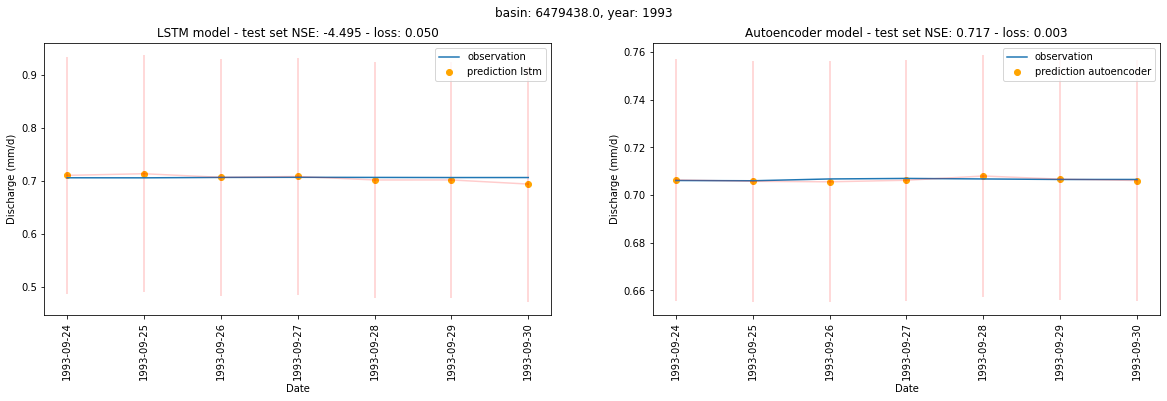

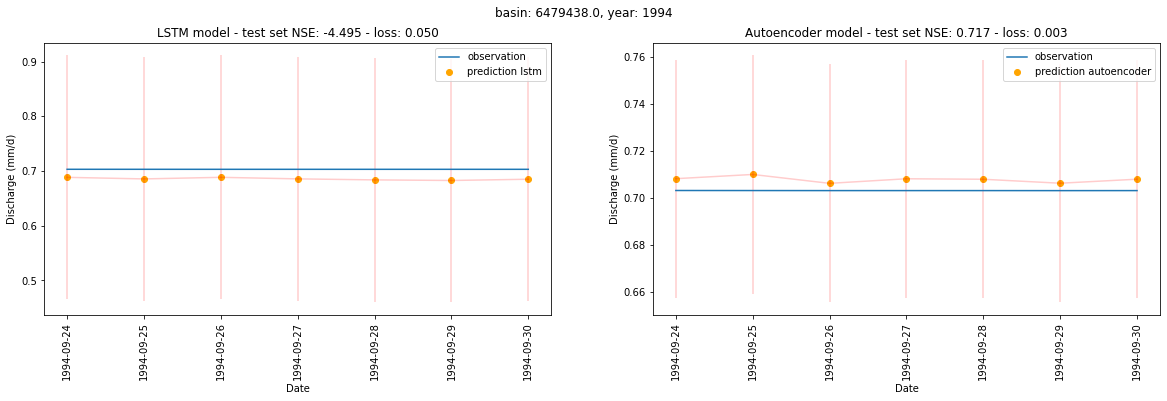

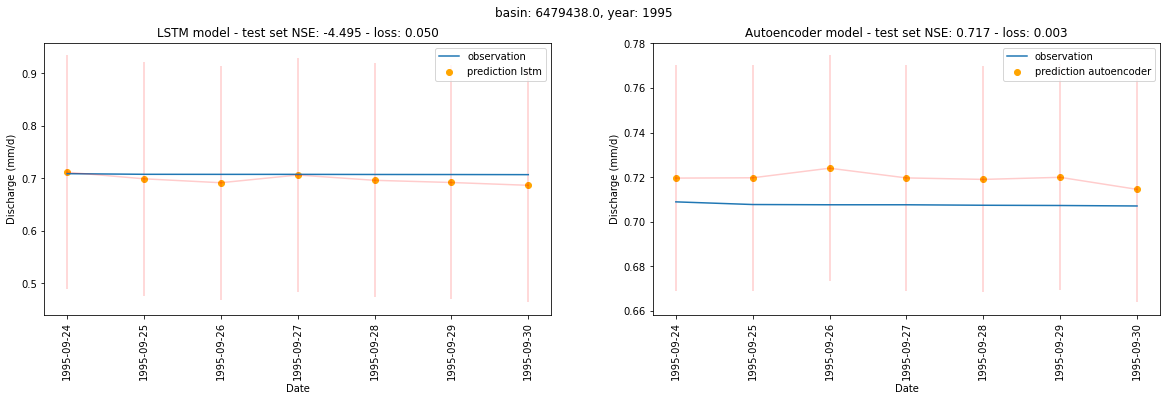

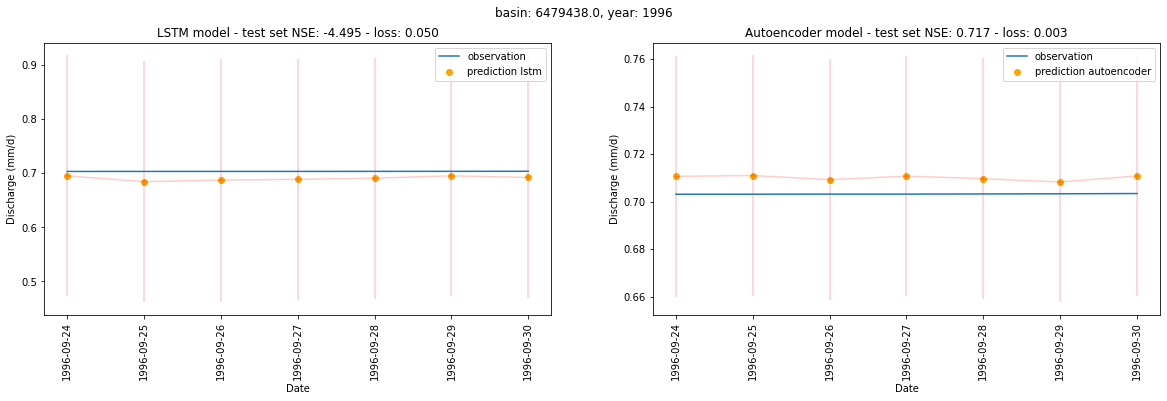

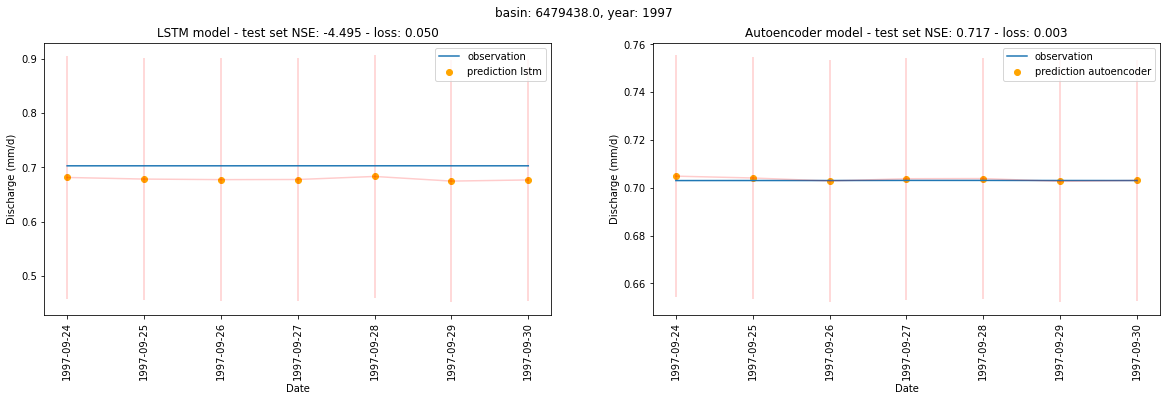

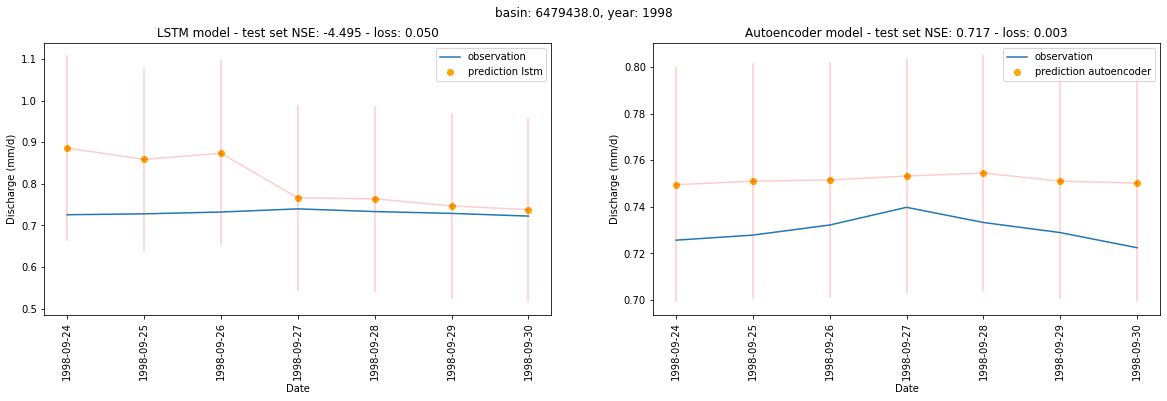

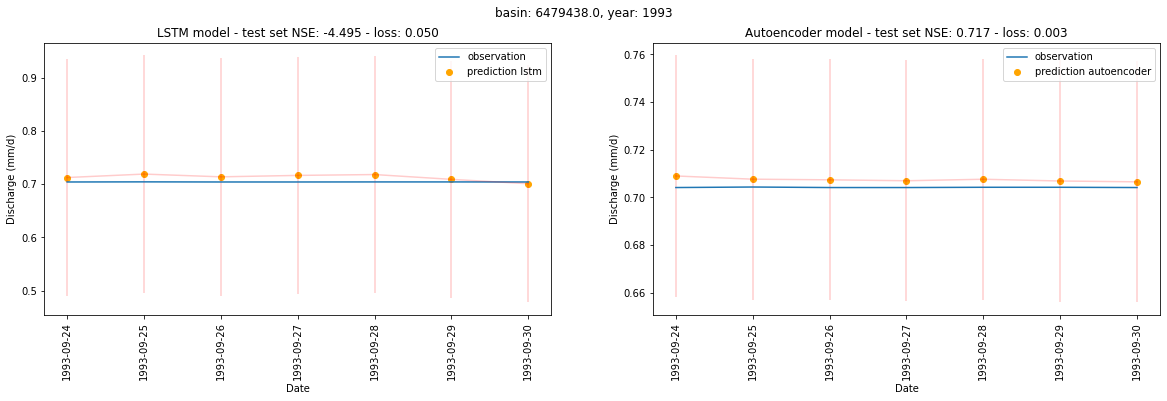

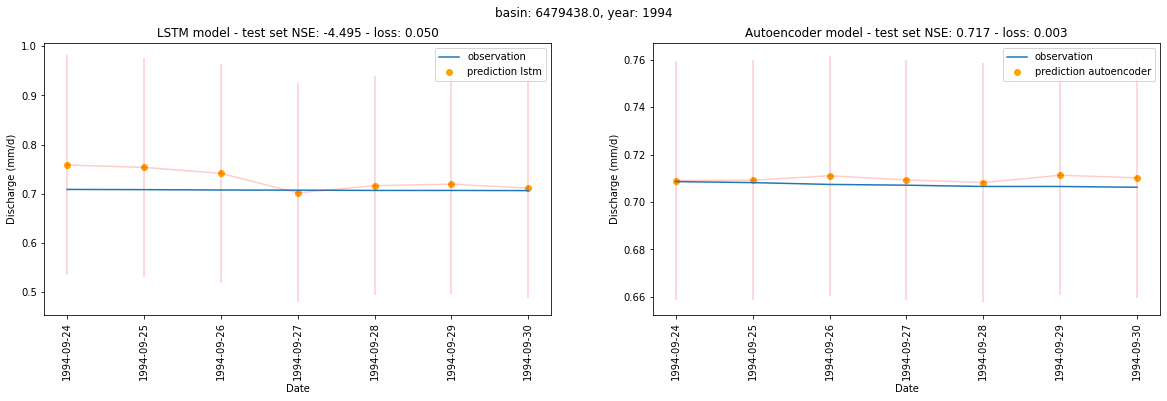

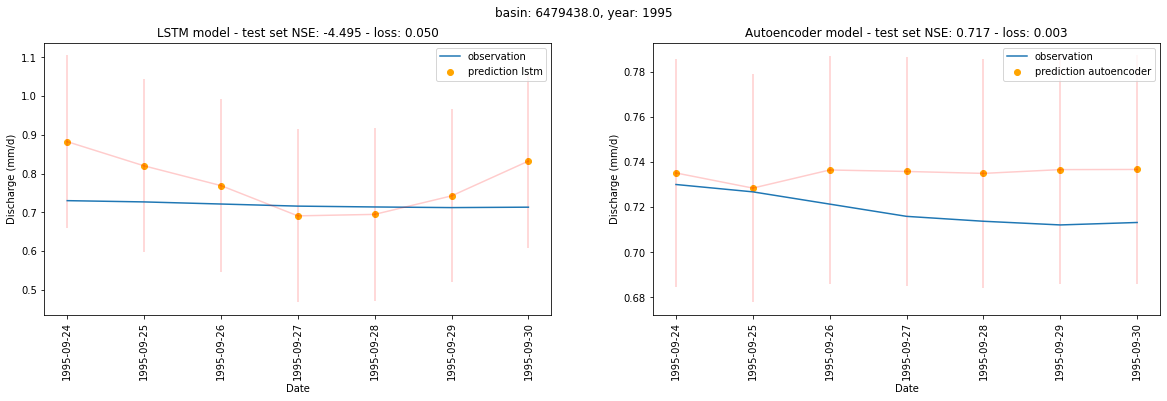

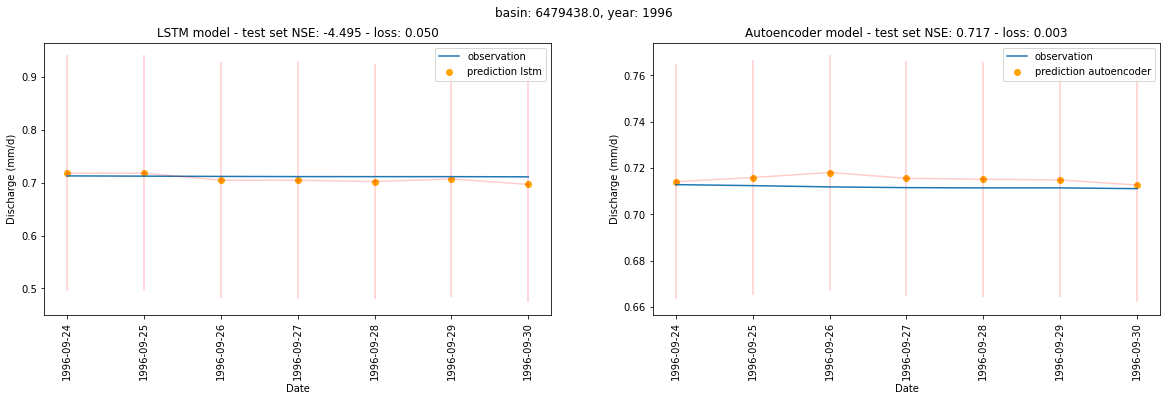

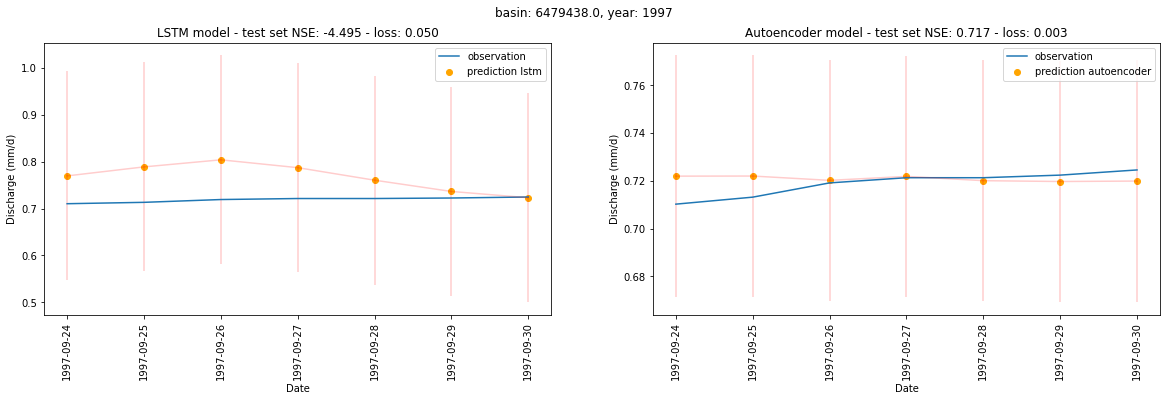

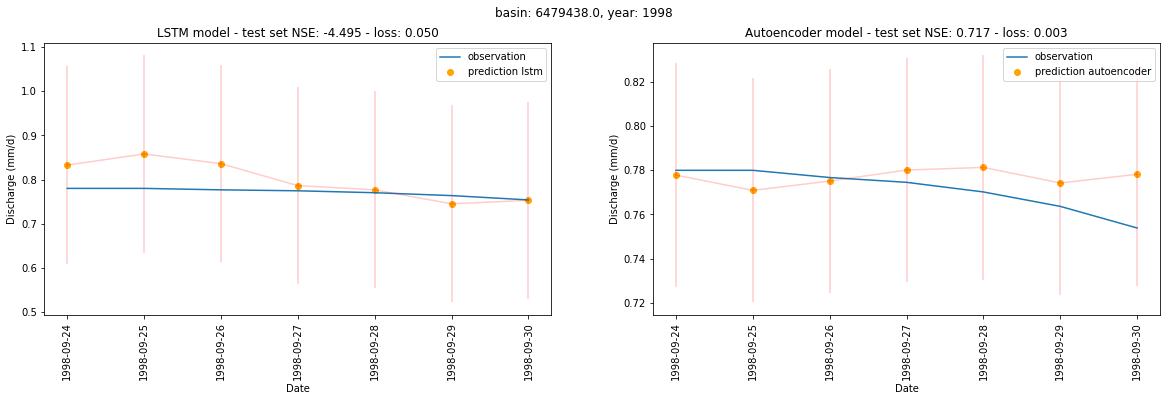

In [52]:
#last 7 days for an average random basin
for index in index_average_one:
  plot(index,  y_pred1_rec, y_pred2_rec)

The average basins presents for some predicted weeks the same behaviour of the arid ones, for other ones the fluctuations are more present. For this specific basin the loss value found for the LSTM is small, suggesting that this basin is more prone to be average-arid than average-humid, confirming that the Autoencoder acts slightly better on arid basins than humid ones.

## Conclusions

To sum up we observe how the encoder allow the model to obtain lower values for the loss as well as higher values for the NSE which mean that, in general, it makes the model a better hydrological predictor. 
This improvement can mostly be seen on arid basins, however better performance was obtained for all type of basins.

Although the model has improved with the encoder it has been seen how better results could be obtained. Here we propose some general ideas that could take the model further on future studies.

### For future developments:
- train the autoencoder model only on different regions, not all basins, to see if less data can produce similar results in a shorter train time.
- adaptive learining rate can be used to increase performances. 
- Try different optimizers and network structures.

### references 
- [1] Albert C. at all. "Learning Summary Statistics for Bayesian Inference with Autoencoders", https://arxiv.org/abs/1611.03530, 28 Jan 2022.
- [2] kratzer F. at all. "Rainfall–runoff modelling using Long Short-Term Memory (LSTM) networks", https://hess.copernicus.org/articles/22/6005/2018/, 22 Nov 2018.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b54647a3-9454-4d36-a570-6b345aa6186e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>